# Imports

In [2]:
import albumentations as A
import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50
from PIL import Image
import tensorflow_hub as hub
import segmentation_models as sm
import torch.nn.functional as F

import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import class_weight
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import glob
from tqdm import tqdm
from FinalModels.ESRGAN.model import ESRGAN

project_root = os.path.abspath(os.path.join(os.getcwd()))
esrgan_path = os.path.join(project_root, "FinalModels", "ESRGAN", "model", "RRDB_PSNR_x4.pth")

# os.environ["TFHUB_CACHE_DIR"] = "./tfhub_cache" 

# SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

# esrgan_model = hub.load(SAVED_MODEL_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

esrgan_model = ESRGAN(model_path=esrgan_path, device=device)

folder_path = "d:\\workspace\\ThesisProject\\TESTS\\images\\LR"

print("Model loaded ESRGAN: ", esrgan_model)
print("Current device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print(f"Using device: {torch.device("cuda" if torch.cuda.is_available() else "cpu")}")




d:\Programs\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Programs\Python\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.2' (you have '2.0.1'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# FUNCTIONS

In [ ]:
def preprocess_image_esrgan(image_path, device):
    """Loads an image from a path, converts it to RGB, and preprocesses it for the model."""
    img = Image.open(image_path).convert("RGB")
    transform = transforms.ToTensor()  
    img = transform(img).unsqueeze(0).to(device)  
    return img

def enhance_image(image_path, model, device):
    """Enhances an image using the ESRGAN model."""
    # Preprocess the image
    # start = time.time()
    img = preprocess_image_esrgan(image_path, device)
    
    # Resize the image once before feeding to the model (if needed)
    resized_img = F.interpolate(img, size=(224, 224), mode='bicubic', align_corners=False)

    # Perform super-resolution
    with torch.no_grad():
        sr_image = model(resized_img)
    
    # print("Images shape: ", "Original:", img.shape, "SR:", sr_image.shape)
    # print("Time Taken: %f seconds" % (time.time() - start))
    
    return img, sr_image  # Return both original and enhanced images


def downscale_image(image, scale_factor=4):
    """Scales down images using bicubic downsampling."""
    _, _, h, w = image.shape
    new_h, new_w = h // scale_factor, w // scale_factor
    image = F.interpolate(image, size=(new_h, new_w), mode='bicubic', align_corners=False)
    return image

def evaluate_performance(hr_image, sr_image):
    """Evaluates the performance of the super-resolved image using PSNR."""
    print("Shape before eval hr:", hr_image.shape)
    print("Shape before eval sr:", sr_image.shape)
    
    sr_image = F.interpolate(sr_image, size=hr_image.shape[2:], mode='bilinear', align_corners=False)

    print("final Shape hr:", hr_image.shape)
    print("final Shape sr:", sr_image.shape)

    if hr_image.shape != sr_image.shape:
        print(f"Shape mismatch: HR {hr_image.shape}, SR {sr_image.shape}")
        return None  

    mse = F.mse_loss(sr_image, hr_image)
    
    if mse == 0:
        print("PSNR: Infinite (identical images)")
        return float('inf')  
    
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))

    print("=============PSNR Achieved: %f==============" % psnr.item())
    return psnr


def compare_images(hr_image, lr_image, sr_image, psnr):
    """Compare the images by displaying them and printing PSNR."""
    sr_image = F.interpolate(sr_image, size=hr_image.shape[2:], mode='bicubic', align_corners=False)

    def process_image(img):
        """Convert PyTorch tensor to NumPy array with correct shape."""
        if isinstance(img, torch.Tensor):
            img = img.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert (3, H, W) to (H, W, 3)
        else:
            img = np.squeeze(img)  # If already NumPy, just squeeze
            if img.ndim == 3 and img.shape[0] in [1, 3]:  # If channel-first, convert to channel-last
                img = np.transpose(img, (1, 2, 0))
        return img


    hr_image = hr_image.cpu().numpy() if isinstance(hr_image, torch.Tensor) else hr_image
    lr_image = lr_image.cpu().numpy() if isinstance(lr_image, torch.Tensor) else lr_image
    sr_image = sr_image.cpu().numpy() if isinstance(sr_image, torch.Tensor) else sr_image
    
    hr_image = np.clip(hr_image, 0, 1)
    lr_image = np.clip(lr_image, 0, 1)
    sr_image = np.clip(sr_image, 0, 1)

    hr_image = process_image(hr_image)
    lr_image = process_image(lr_image)
    sr_image = process_image(sr_image)

    print("Evaluation Images shape:", hr_image.shape, lr_image.shape, sr_image.shape)

    plt.rcParams['figure.figsize'] = [15, 10]
    fig, axes = plt.subplots(1, 3)
    fig.tight_layout()

    plt.subplot(131)
    plot_image(hr_image, title="Original")
    
    plt.subplot(132)
    plot_image(lr_image, title="x4 Bicubic")
    
    plt.subplot(133)
    plot_image(sr_image, title="Super Resolution")
    
    plt.show(block=False)

def save_image_esrgan(image, save_path, device, filename, size=224):
    """Saves the image tensor to a file after interpolation and conversion, running on GPU if needed."""
    
    # Ensure image is on the specified device (GPU or CPU)
    image = image.to(device)
    # print("Shape before interpolate:", image.shape)
    
    # Perform bicubic interpolation to the specified size
    image = F.interpolate(image, (size, size), mode='bicubic', align_corners=False).squeeze(0)
    
    # Convert from (C, H, W) to (H, W, C)
    image = image.squeeze().permute(1, 2, 0)
    
    # Move tensor to CPU before converting to NumPy
    image = image.cpu().numpy()
    
    # Rescale image values to [0, 255] and ensure they are uint8
    image = np.clip(image * 255, 0, 255).astype(np.uint8)
    
    print("Shape before save:", image.shape)
    
    # Convert to a PIL image and save
    pil_image = Image.fromarray(image)
    try:
        pil_image.save(os.path.join(save_path, filename + '.png'), format='PNG')  # Ensure .png extension
        print(f"Saved {filename} at {save_path}")
    except Exception as e:
        print(f"Error saving {filename}: {e}")
    
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)


def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)


def pad_to_square(image):
    # Get original dimensions
    old_h, old_w = image.shape[:2]
    
    # Find the larger dimension to make the image square
    max_dim = max(old_h, old_w)
    
    # Calculate padding
    pad_h = (max_dim - old_h) // 2
    pad_w = (max_dim - old_w) // 2
    
    # Ensure padding is non-negative and compatible
    padded_image = tf.image.pad_to_bounding_box(image, pad_h, pad_w, max_dim, max_dim)
    
    # Handle any excess due to rounding differences
    padded_image = tf.image.resize_with_crop_or_pad(padded_image, max_dim, max_dim)
    
    return padded_image

def get_image_index(file_name, image_dir="./data/DATASET/TRAIN_UNET/enhanced_images/*.jpg"):
    """
    Retrieves the index of an image file name in the list of loaded images.
    
    Args:
        file_name (str): The file name of the image (e.g., 'image1.jpg').
        image_dir (str): The directory path of the images.

    Returns:
        int: The index of the image in the list of images, or -1 if not found.
    """
    for idx, img_path in enumerate(glob.glob(image_dir)):
        if file_name in img_path:
            return idx
    return -1

def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

def plot_image_tensor(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

def load_images_and_masks(image_path, mask_path):
    SIZE_X, SIZE_Y = 128, 128

    # Load images
    images = []
    for img in glob.glob(image_path):
        img = cv2.imread(img, 1)
        img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    images = np.array(images)

    # Load masks
    masks = []
    for mask in glob.glob(mask_path):
        mask = cv2.imread(mask, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
        masks.append(mask)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)  # Add channel dimension
    masks = (masks > 0).astype(np.uint8)    # Binarize mask

    return images, masks

# Training and evaluation loop
def train_model(model, dataloader, val_dataloader, optimizer, criterion, epochs, device):
    # Initialize lists to store metrics for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Create a tqdm progress bar for the dataloader
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", ncols=100, unit="batch")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=running_loss/total, accuracy=correct/total)

        # Calculate training accuracy
        train_loss = running_loss / len(dataloader)
        train_acc = correct / total

        # Evaluate on the validation set
        val_acc, val_loss = evaluate_model(model, val_dataloader, criterion)

        # Save metrics for this epoch
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Return the history for further processing (such as saving or plotting)
    history = {
        'epoch': range(1, epochs + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    return history  # Return the history dictionary


# Evaluation loop
def evaluate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    return val_acc, val_loss / len(dataloader)

def test_model(model, test_dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# Define the function for predicting and measuring speed
def predict_image(model, image_path, device, class_labels):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ResNet's requirements
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model
    image = image.to(device)

    # Start time for inference
    start_time = time.time()

    # Perform inference
    model.eval()
    with torch.no_grad():
        outputs = model(image)

    # Calculate prediction probabilities using softmax
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Get the predicted class and its probability
    predicted_class_index = probabilities.argmax().item()
    predicted_class = class_labels[predicted_class_index]
    prediction_time = time.time() - start_time

    return predicted_class, prediction_time, probabilities[0]  # Return class, time, and probabilities

def predict_image_with_debug(model, image_path, device, class_labels):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    # Start time for inference
    start_time = time.time()

    # Perform inference
    model.eval()
    with torch.no_grad():
        logits = model(image)  # Raw logits from the model

    # Calculate probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Plot class probabilities
    plt.bar(range(len(class_labels)), probabilities[0].cpu().numpy())
    plt.xticks(range(len(class_labels)), class_labels, rotation=90)
    plt.show()

    # Get predicted class and its probability
    predicted_class_index = probabilities.argmax().item()
    predicted_class = class_labels[predicted_class_index]
    confidence = probabilities.max().item()
    prediction_time = time.time() - start_time

    return predicted_class, confidence, prediction_time

def plot_from_history(history):
    # Extract data from the history dictionary
    epochs = len(history['epoch'])
    train_losses = history['train_loss']
    val_losses = history['val_loss']
    train_accuracies = history['train_accuracy']
    val_accuracies = history['val_accuracy']

    # Plot the metrics
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Save the plot
    plt.tight_layout()
    plt.savefig('training_history.png')  # Save the plot as a PNG image
    plt.show()
    
def get_class_labels(dataset_dir):
    # Get all folder names in the directory, which are your class labels
    class_labels = sorted(os.listdir(dataset_dir))  # Assuming each subfolder is a class
    return class_labels

# Dataset Preparation

In [ ]:
train_dir = './DATASET/TRAIN'
enhancedtrain_dir = './DATASET/TRAIN_ESRGAN2'
test_dir = './DATASET/TEST'
enhancedtest_dir = './DATASET/TEST_ESRGAN2'
val_dir = './DATASET/VALIDATION'
enhancedval_dir = './DATASET/VALIDATION_ESRGAN2'

seed = 42
np.random.seed(seed)
random.seed(seed)


In [ ]:


# Hyperparameters
img_height, img_width = 224, 224
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  


# Data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=(0.8, 1.2)),
    # transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((img_height, img_width), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


val_test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=val_test_transform) # train transform for augmented
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Enhanced datasets
enhanced_train_dataset = datasets.ImageFolder(enhancedtrain_dir, transform=val_test_transform) # train transform for augmented
enhanced_val_dataset = datasets.ImageFolder(enhancedval_dir, transform=val_test_transform)
enhanced_test_dataset = datasets.ImageFolder(enhancedtest_dir, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

enhanced_train_loader = DataLoader(enhanced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
enhanced_val_loader = DataLoader(enhanced_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
enhanced_test_loader = DataLoader(enhanced_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Number of images in training set: {len(train_dataset)}")
print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")

print(f"Number of images in enhanced training set: {len(enhanced_train_dataset)}")
print(f"Number of images in enhanced validation set: {len(enhanced_val_dataset)}")
print(f"Number of images in enhanced test set: {len(enhanced_test_dataset)}")


Number of images in training set: 1679
Number of images in validation set: 474
Number of images in test set: 246
Number of images in enhanced training set: 1679
Number of images in enhanced validation set: 474
Number of images in enhanced test set: 246


# PYTORCH (BASELINE)

In [117]:
learning_rate = 0.001
epochs = 5


torch_baseline = resnet50(weights="IMAGENET1K_V1")
torch_baseline = torch_baseline.to(device)


# freeze = True
# for name, layer in torch_baseline.named_modules():
#     # Explicitly freeze all layers up to layer3
#     if 'layer4' in name:
#         freeze = False  # Start unfreezing at layer3
#     if freeze:
#         for param in layer.parameters():
#             param.requires_grad = False
#     else:
#         for param in layer.parameters():
#             param.requires_grad = True


# FREEZE ALL LAYERS
for name, layer in torch_baseline.named_modules():
    for param in layer.parameters():
        param.requires_grad = False


class BaselineResNet(nn.Module):
    def __init__(self, base_model, num_classes=18):
        super(BaselineResNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude top layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)  # 2048 (gap) + 2048 (gmp) = 4096

    def forward(self, x):
        x = self.base_model(x)
        gap = self.gap(x).view(x.size(0), -1)
        x = self.fc(gap)
        return x


torch_baseline_model = BaselineResNet(torch_baseline).to(device)

learning_rate = .001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, torch_baseline_model.parameters()), lr=learning_rate)


for name, layer in torch_baseline.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')


: False
conv1: False
bn1: False
relu: False
maxpool: False
layer1: False
layer1.0: False
layer1.0.conv1: False
layer1.0.bn1: False
layer1.0.conv2: False
layer1.0.bn2: False
layer1.0.conv3: False
layer1.0.bn3: False
layer1.0.relu: False
layer1.0.downsample: False
layer1.0.downsample.0: False
layer1.0.downsample.1: False
layer1.1: False
layer1.1.conv1: False
layer1.1.bn1: False
layer1.1.conv2: False
layer1.1.bn2: False
layer1.1.conv3: False
layer1.1.bn3: False
layer1.1.relu: False
layer1.2: False
layer1.2.conv1: False
layer1.2.bn1: False
layer1.2.conv2: False
layer1.2.bn2: False
layer1.2.conv3: False
layer1.2.bn3: False
layer1.2.relu: False
layer2: False
layer2.0: False
layer2.0.conv1: False
layer2.0.bn1: False
layer2.0.conv2: False
layer2.0.bn2: False
layer2.0.conv3: False
layer2.0.bn3: False
layer2.0.relu: False
layer2.0.downsample: False
layer2.0.downsample.0: False
layer2.0.downsample.1: False
layer2.1: False
layer2.1.conv1: False
layer2.1.bn1: False
layer2.1.conv2: False
layer2.1.bn

In [ ]:
baseline_history = train_model(torch_baseline_model, enhanced_train_loader, enhanced_val_loader, optimizer, criterion, epochs=epochs, device=device)

In [102]:
# Test model and evaluate performance
y_true, y_pred = test_model(torch_baseline_model, enhanced_test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       1.00      1.00      1.00        11
 Acanthurus Nigrofuscus       0.95      1.00      0.98        21
   Balistapus Undulatus       1.00      1.00      1.00         5
 Canthigaster Valentini       1.00      1.00      1.00        14
 Chaetodon Trifascialis       1.00      1.00      1.00        19
   Hemigymnus Fasciatus       1.00      0.96      0.98        24
  Hemigymnus Melapterus       1.00      1.00      1.00         5
        Lutjanus fulvus       1.00      1.00      1.00        20
     Myripristis Kuntee       1.00      1.00      1.00        45
Neoglyphidodon Nigroris       0.67      0.67      0.67         3
      Neoniphon Sammara       1.00      1.00      1.00        29
 Pempheris Vanicolensis       1.00      1.00      1.00         4
Pomacentrus Moluccensis       1.00      1.00      1.00        18
               Scaridae       1.00      1.00      1.00         6


['Abudefduf Vaigiensis', 'Acanthurus Nigrofuscus', 'Balistapus Undulatus', 'Canthigaster Valentini', 'Chaetodon Trifascialis', 'Hemigymnus Fasciatus', 'Hemigymnus Melapterus', 'Lutjanus fulvus', 'Myripristis Kuntee', 'Neoglyphidodon Nigroris', 'Neoniphon Sammara', 'Pempheris Vanicolensis', 'Pomacentrus Moluccensis', 'Scaridae', 'Scolopsis Bilineata', 'Siganus Fuscescens', 'Zanclus Cornutus', 'Zebrasoma Scopas']
Logits: tensor([[-3.2724, -1.4589, -3.1128, -2.6746, -1.4504, -1.7530, -2.3411, -2.3090,
         -1.2983, -3.0764, -1.9754, -1.9210, -0.5747, -2.5510, -2.9525, -3.5631,
         -2.1959, -2.3216]], device='cuda:0')


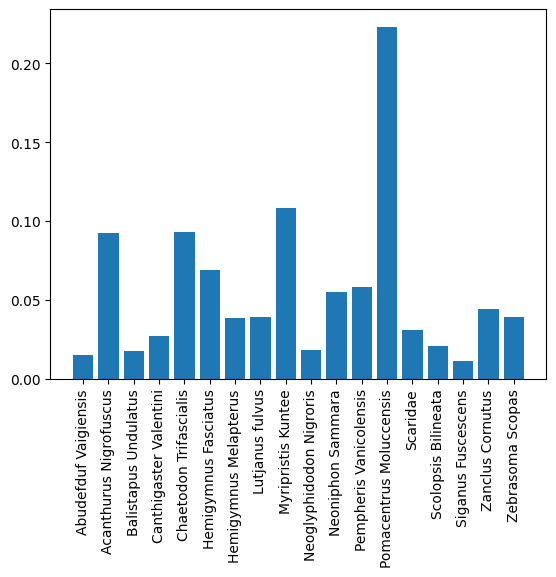

Predicted Class: Pomacentrus Moluccensis
Confidence: 22.32%
Inference Time: 0.1945 seconds


In [75]:
class_labels = train_dataset.classes
print(class_labels)


image_path = "./data/DATASET/TEST/Lutjanus fulvus/fish_000000819594_03407.png"

random_path = './sample_images/SAMPLE_LUTJANUS.jpg'
predicted_class, confidence, prediction_time = predict_image_with_debug(torch_baseline_model, random_path, device, class_labels)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence * 100:.2f}%") 
print(f"Inference Time: {prediction_time:.4f} seconds")


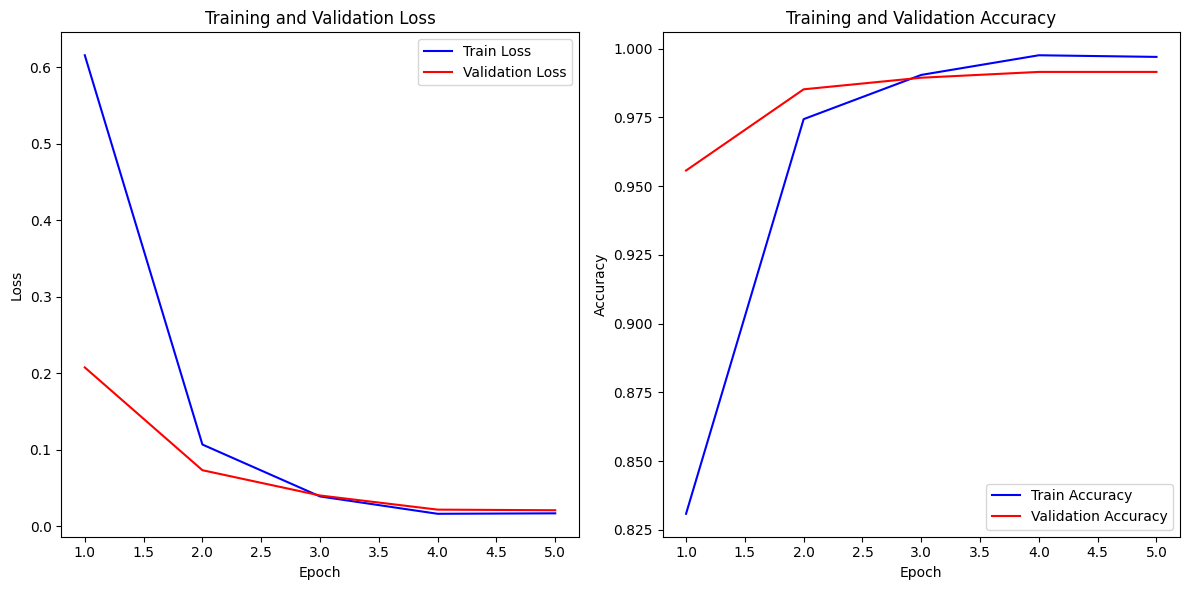

In [91]:
plot_from_history(baseline_history)

**VIEW HISTORY FROM A FILE** 

In [ ]:

history_df = pd.read_csv('training_history.csv') #filename
history = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}

# Plot the history
plot_from_history(history)

**Save Model - MAKE FILENAME MEANINGFUL**

In [77]:

df = pd.DataFrame(baseline_history)
# HISTORY OR GRAPH
df.to_csv('./saved_models/history/torch_history_baselineb32notauglr001enhancedvallacc85testacc82traintime2m_57sepoch5ratio70_20_10epoch5.csv', index=False)

# MODEL
torch.save(torch_baseline_model, './saved_models/torch_baselineb32notauglr001enhancedvallacc85testacc82traintime2m_57sepoch5ratio70_20_10epoch5.pth')

#WEIGHTS
torch.save(torch_baseline_model.state_dict(), './saved_models/weights/torch_weights_baselineb32notauglr001enhancedvallacc85testacc82traintime2m_57sepoch5ratio70_20_10epoch5.pth')

# PYTORCH (PROPOSED)

In [119]:
learning_rate = 0.001
epochs = 5


torch_proposed = resnet50(weights="IMAGENET1K_V1")
torch_proposed = torch_proposed.to(device)

# Freeze the initial 39 layers
# freeze = True
# for name, layer in torch_proposed.named_modules():
#     # Explicitly freeze all layers up to layer3
#     if 'layer4' in name:
#         freeze = False  # Start unfreezing at layer3
#     if freeze:
#         for param in layer.parameters():
#             param.requires_grad = False
#     else:
#         for param in layer.parameters():
#             param.requires_grad = True

# FREEZE ALL LAYERS
for name, layer in torch_proposed.named_modules():
    for param in layer.parameters():
        param.requires_grad = False


class ProposedResNet(nn.Module):
    def __init__(self, base_model, num_classes=18, dropout_rate=0.2):
        super(ProposedResNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude top layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.gmp = nn.AdaptiveMaxPool2d((1, 1))
        self.bn = nn.BatchNorm1d(4096)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(4096, num_classes)  # 2048 (gap) + 2048 (gmp) = 4096

    def forward(self, x):
        x = self.base_model(x)

        gap = self.gap(x).view(x.size(0), -1)
        gmp = self.gmp(x).view(x.size(0), -1)
        concat = torch.cat((gap, gmp), dim=1)
        bn = self.bn(concat)
        dp = self.dropout(bn)

        
        x = self.fc(dp)

        return x


torch_proposed_model = ProposedResNet(torch_proposed).to(device)

learning_rate = .001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, torch_proposed_model.parameters()), lr=learning_rate)


for name, layer in torch_proposed_model.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')


: True
base_model: False
base_model.0: False
base_model.1: False
base_model.2: False
base_model.3: False
base_model.4: False
base_model.4.0: False
base_model.4.0.conv1: False
base_model.4.0.bn1: False
base_model.4.0.conv2: False
base_model.4.0.bn2: False
base_model.4.0.conv3: False
base_model.4.0.bn3: False
base_model.4.0.relu: False
base_model.4.0.downsample: False
base_model.4.0.downsample.0: False
base_model.4.0.downsample.1: False
base_model.4.1: False
base_model.4.1.conv1: False
base_model.4.1.bn1: False
base_model.4.1.conv2: False
base_model.4.1.bn2: False
base_model.4.1.conv3: False
base_model.4.1.bn3: False
base_model.4.1.relu: False
base_model.4.2: False
base_model.4.2.conv1: False
base_model.4.2.bn1: False
base_model.4.2.conv2: False
base_model.4.2.bn2: False
base_model.4.2.conv3: False
base_model.4.2.bn3: False
base_model.4.2.relu: False
base_model.5: False
base_model.5.0: False
base_model.5.0.conv1: False
base_model.5.0.bn1: False
base_model.5.0.conv2: False
base_model.5.0.

In [111]:
# Train model
proposed_history = train_model(torch_proposed_model, enhanced_train_loader, enhanced_val_loader, optimizer, criterion, epochs=epochs, device=device)

Epoch 1/5: 100%|████████████████████| 53/53 [01:30<00:00,  1.72s/batch, accuracy=0.875, loss=0.0148]


Epoch 1/5: Train Loss=0.4697, Train Acc=0.8749, Val Loss=0.1067, Val Acc=0.9747


Epoch 2/5: 100%|███████████████████| 53/53 [01:30<00:00,  1.70s/batch, accuracy=0.987, loss=0.00128]


Epoch 2/5: Train Loss=0.0405, Train Acc=0.9875, Val Loss=0.0574, Val Acc=0.9873


Epoch 3/5: 100%|██████████████████| 53/53 [01:29<00:00,  1.70s/batch, accuracy=0.999, loss=0.000267]


Epoch 3/5: Train Loss=0.0084, Train Acc=0.9994, Val Loss=0.0406, Val Acc=0.9873


Epoch 4/5: 100%|██████████████████| 53/53 [01:30<00:00,  1.70s/batch, accuracy=0.998, loss=0.000192]


Epoch 4/5: Train Loss=0.0061, Train Acc=0.9976, Val Loss=0.0396, Val Acc=0.9873


Epoch 5/5: 100%|██████████████████| 53/53 [01:29<00:00,  1.69s/batch, accuracy=0.999, loss=0.000131]


Epoch 5/5: Train Loss=0.0042, Train Acc=0.9988, Val Loss=0.0441, Val Acc=0.9873


In [112]:

# Test model and evaluate performance
y_true, y_pred = test_model(torch_proposed_model, enhanced_test_loader)

print("\nClassification Report:")
class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.92      1.00      0.96        11
 Acanthurus Nigrofuscus       0.95      1.00      0.98        21
   Balistapus Undulatus       1.00      1.00      1.00         5
 Canthigaster Valentini       0.93      1.00      0.97        14
 Chaetodon Trifascialis       0.95      1.00      0.97        19
   Hemigymnus Fasciatus       1.00      0.96      0.98        24
  Hemigymnus Melapterus       1.00      1.00      1.00         5
        Lutjanus fulvus       1.00      1.00      1.00        20
     Myripristis Kuntee       1.00      1.00      1.00        45
Neoglyphidodon Nigroris       1.00      0.67      0.80         3
      Neoniphon Sammara       1.00      0.97      0.98        29
 Pempheris Vanicolensis       1.00      1.00      1.00         4
Pomacentrus Moluccensis       1.00      1.00      1.00        18
               Scaridae       1.00      1.00      1.00         6


**TEST ON SAMPLE IMAGE**

['Abudefduf Vaigiensis', 'Acanthurus Nigrofuscus', 'Balistapus Undulatus', 'Canthigaster Valentini', 'Chaetodon Trifascialis', 'Hemigymnus Fasciatus', 'Hemigymnus Melapterus', 'Lutjanus fulvus', 'Myripristis Kuntee', 'Neoglyphidodon Nigroris', 'Neoniphon Sammara', 'Pempheris Vanicolensis', 'Pomacentrus Moluccensis', 'Scaridae', 'Scolopsis Bilineata', 'Siganus Fuscescens', 'Zanclus Cornutus', 'Zebrasoma Scopas']
Logits: tensor([[-3.0945,  2.0444, -0.5937,  0.0777,  2.2522,  0.9909,  0.2614,  0.1096,
          0.7667,  0.4534,  1.5969,  2.7444,  4.0471,  0.9006,  0.5592, -1.0011,
          2.3171,  1.7849]], device='cuda:0')


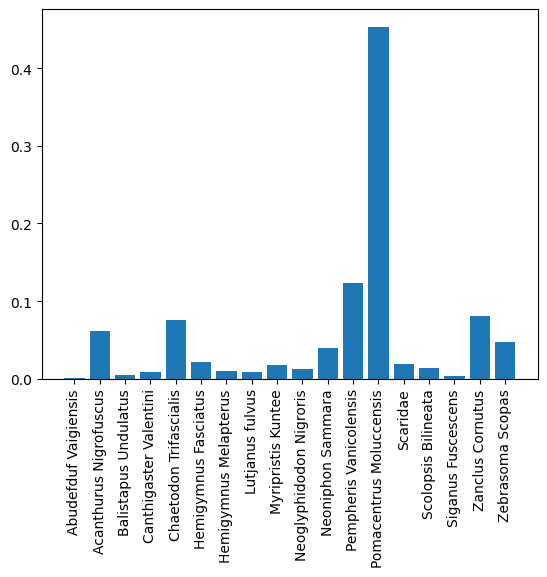

Predicted Class: Pomacentrus Moluccensis
Confidence: 45.37%
Inference Time: 0.2349 seconds


In [106]:
class_labels = train_dataset.classes
print(class_labels)


image_path = "./data/DATASET/TEST/Lutjanus fulvus/fish_000000819594_03407.png"

random_path = './sample_images/SAMPLE_LUTJANUS.jpg'
predicted_class, confidence, prediction_time = predict_image_with_debug(torch_proposed_model, random_path, device, class_labels)

predicted_class_label = predicted_class


print(f"Predicted Class: {predicted_class_label}")
print(f"Confidence: {confidence * 100:.2f}%") 
print(f"Inference Time: {prediction_time:.4f} seconds")


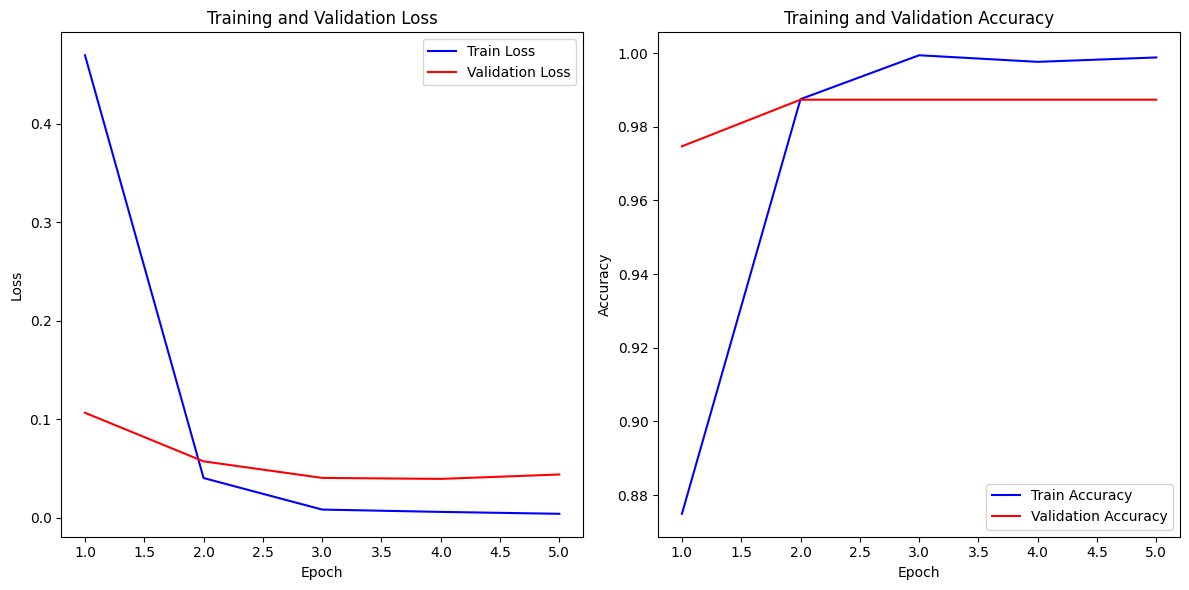

In [113]:
plot_from_history(proposed_history)

In [ ]:
history_df = pd.read_csv('./saved_models/history/torch_history_proposedb32notaug1lr001notenhancedvallacc89testacc88traintime2m57sepoch5ratio70_20_10.csv')

history = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}

plot_from_history(history)

**SAVE MODEL: MAKE FILENAME MEANINGFUL**

In [16]:

df = pd.DataFrame(proposed_history)
# HISTORY OR GRAPH
df.to_csv('./saved_models/history/torch_history_proposedb32notaug1lr001enhancedvallacc94testacc95traintime3m17sepoch5ratio70_20_10withBatchNorm.csv', index=False)

# MODEL
torch.save(torch_proposed_model, './saved_models/model/torch_proposedb32notaug1lr001enhancedvallacc94testacc95traintime3m17sepoch5ratio70_20_10withBatchNorm.pth')

# WEIGHTS
torch.save(torch_proposed_model.state_dict(), './saved_models/weights/torch_weights_proposedb32notaug1lr001enhancedvallacc94testacc95traintime3m17sepoch5ratio70_20_10withBatchNorm.pth')

# ESRGAN

**RUN IF ENHANCEMENT SUDDENLY STOPPED**

In [3]:

input_folder = './DATASET/TRAIN'
output_folder = './DATASET/TRAIN_ESRGAN2'

os.makedirs(output_folder, exist_ok=True)

found = False


target_file = 'fish_000013609594_03546.png' 
target_folder = 'Lutjanus fulvus' 

for class_name in os.listdir(input_folder):


    if class_name == target_folder:

        class_path = os.path.join(input_folder, class_name)

        if os.path.isdir(class_path):
            enhanced_class_path = os.path.join(output_folder, class_name)
            os.makedirs(enhanced_class_path, exist_ok=True)

            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                

                if not found:
                    if image_file == target_file:
                        found = True 
                        continue
                    else:
                        print(f"Skipping file: {image_file}")
                        continue  

                if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):  
                    print(f"Processing {image_file}...")
                    original, enhance_image_result = enhance_image(image_path, esrgan_model, device)
                    print(f"FINISHED {image_file}: ")
                    save_image_esrgan(enhance_image_result, os.path.join(enhanced_class_path), device, image_file.split('.')[0])



print("Image enhancement complete. Enhanced images saved in:", output_folder)

Skipping file: fish_000000819594_03402.png
Skipping file: fish_000000819594_03404.png
Skipping file: fish_000000819594_03405.png
Skipping file: fish_000000819594_03406.png
Skipping file: fish_000000819594_03409.png
Skipping file: fish_000000819594_03411.png
Skipping file: fish_000000819594_03412.png
Skipping file: fish_000000819594_03413.png
Skipping file: fish_000000819594_03415.png
Skipping file: fish_000000819594_03417.png
Skipping file: fish_000000819594_03419.png
Skipping file: fish_000000819594_03420.png
Skipping file: fish_000000819594_03421.png
Skipping file: fish_000000819594_03423.png
Skipping file: fish_000000819594_03424.png
Skipping file: fish_000000819594_03425.png
Skipping file: fish_000000819594_03426.png
Skipping file: fish_000000819594_03427.png
Skipping file: fish_000000819594_03428.png
Skipping file: fish_000000819594_03432.png
Skipping file: fish_000004939594_03461.png
Skipping file: fish_000004939594_03462.png
Skipping file: fish_000004939594_03463.png
Skipping fi

**ONLY RUN UNFINISHED FOLDERS**

In [6]:

input_folder = './DATASET/VALIDATION'
output_folder = './DATASET/VALIDATION_ESRGAN2'

os.makedirs(output_folder, exist_ok=True)

# finished_folders = ['Acanthurus Nigrofuscus', 'Canthigaster Valentini', 'Chaetodon Trifascialis',
#                     'Hemigymnus Fasciatus', 'Neoniphon Sammara', 'Pomacentrus Moluccensis',
#                     'Myripristis Kuntee', 'Lutjanus fulvus'
#                     ,'Abudefduf Vaigiensis', 'Balistapus Undulatus', 'Hemigymnus Melapterus', 'Neoglyphidodon Nigroris', 'Pempheris Vanicolensis'] #new added 10 species

finished_folders = ['Acanthurus Nigrofuscus','Abudefduf Vaigiensis','Balistapus Undulatus', 'Canthigaster Valentini', 
                    'Chaetodon Trifascialis', 'Hemigymnus Fasciatus', 'Hemigymnus Melapterus', 'Lutjanus fulvus',
                    ] #new added 10 species

for class_name in os.listdir(input_folder):

    # if class_name in finished_folders:
    #     continue 

    class_path = os.path.join(input_folder, class_name)

    if os.path.isdir(class_path):
        enhanced_class_path = os.path.join(output_folder, class_name)
        os.makedirs(enhanced_class_path, exist_ok=True)

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                
                print(f"Processing {image_file}...")
                original, enhance_image_result = enhance_image(image_path, esrgan_model, device)
                print(f"FINISHED {image_file}: ")
                save_image_esrgan(enhance_image_result, os.path.join(enhanced_class_path), device, image_file.split('.')[0])

print("Image enhancement complete. Enhanced images saved in:", output_folder)

Processing fish_000001719594_03398.png...
FINISHED fish_000001719594_03398.png: 
Shape before save: (224, 224, 3)
Saved fish_000001719594_03398 at ./DATASET/VALIDATION_ESRGAN2\Abudefduf Vaigiensis
Processing fish_000003709594_03460.png...
FINISHED fish_000003709594_03460.png: 
Shape before save: (224, 224, 3)
Saved fish_000003709594_03460 at ./DATASET/VALIDATION_ESRGAN2\Abudefduf Vaigiensis
Processing fish_000005829592_03459.png...
FINISHED fish_000005829592_03459.png: 
Shape before save: (224, 224, 3)
Saved fish_000005829592_03459 at ./DATASET/VALIDATION_ESRGAN2\Abudefduf Vaigiensis
Processing fish_000005949592_03449.png...
FINISHED fish_000005949592_03449.png: 
Shape before save: (224, 224, 3)
Saved fish_000005949592_03449 at ./DATASET/VALIDATION_ESRGAN2\Abudefduf Vaigiensis
Processing fish_000005949592_03454.png...
FINISHED fish_000005949592_03454.png: 
Shape before save: (224, 224, 3)
Saved fish_000005949592_03454 at ./DATASET/VALIDATION_ESRGAN2\Abudefduf Vaigiensis
Processing fish

**IMAGE COMPARISONS**

(1, 76, 108, 3)
(224, 224, 3)


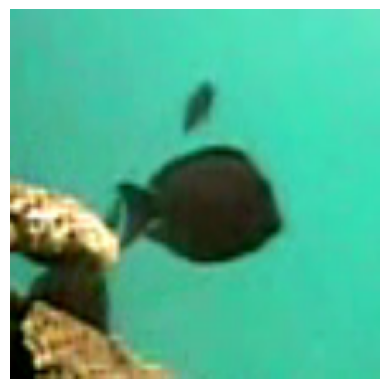

In [140]:
image = preprocess_image('./DATASET/TEST/Acanthurus Nigrofuscus/fish_000026610001_02661.png')

# image = pad_to_square(tf.squeeze(image))
print(image.shape)
image = tf.image.resize(tf.squeeze(image), (224, 224))
print(image.shape)
plot_image_tensor(tf.squeeze(image))

(1, 224, 224, 3)
(224, 224, 3)


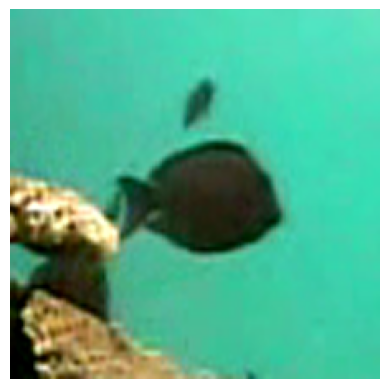

In [141]:
image = preprocess_image('./DATASET/TEST_ESRGAN2/Acanthurus Nigrofuscus/fish_000026610001_02661.png')

# image = pad_to_square(tf.squeeze(image))
print(image.shape)
image = tf.squeeze(image)
# image = tf.image.resize(tf.squeeze(image), (224, 224))
print(image.shape)
plot_image_tensor(image)

# U-NET TESTING AND TRAINING

**WITH ENHANCED IMAGES DATASET**

In [1]:
SIZE_X, SIZE_Y = 224, 224
n_classes = 1

train_images = []
for img_path in glob.glob("./DATASET/TRAIN_UNET/enhanced_images2/*.png"):  

    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    train_images.append(img)


# train_images = tf.clip_by_value(train_images, 0, 255).numpy().astype(np.uint8)  
train_images = np.array(train_images)

train_images_orig = []
for img_path in glob.glob("./DATASET/TRAIN_UNET/images/*.png"):  
    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    train_images_orig.append(img)

train_images_orig = tf.clip_by_value(train_images_orig, 0, 255).numpy().astype(np.uint8)  
train_images_orig = np.array(train_images_orig)


train_masks = []
for mask_path in glob.glob("./DATASET/TRAIN_UNET/mask/*.png"): 
    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
    train_masks.append(mask)


train_masks = np.array(train_masks)

print("Number of training images:", len(train_images))
print("Number of training masks:", len(train_masks))

train_masks = np.expand_dims(train_masks, axis=-1)

train_masks = (train_masks > 0).astype(np.uint8)

X_train_full, X_test, y_train_full, y_test = train_test_split(train_images, train_masks, test_size=0.10, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.10, random_state=0)

print(f"Training images shape: {X_train.shape}")
print(f"Training masks shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}")
print(f"Validation masks shape: {y_val.shape}")
print(f"Test images shape: {X_test.shape}")
print(f"Test masks shape: {y_test.shape}")

print("Number of training images:", len(X_train))
print("Number of training masks:", len(y_train))
print("Number of validation images:", len(X_val))
print("Number of validation masks:", len(y_val))
print("Number of test images:", len(X_test))
print("Number of test masks:", len(y_test))

print(np.unique(train_masks))




NameError: name 'glob' is not defined

0
GT SHAPE =  (128, 128, 1)


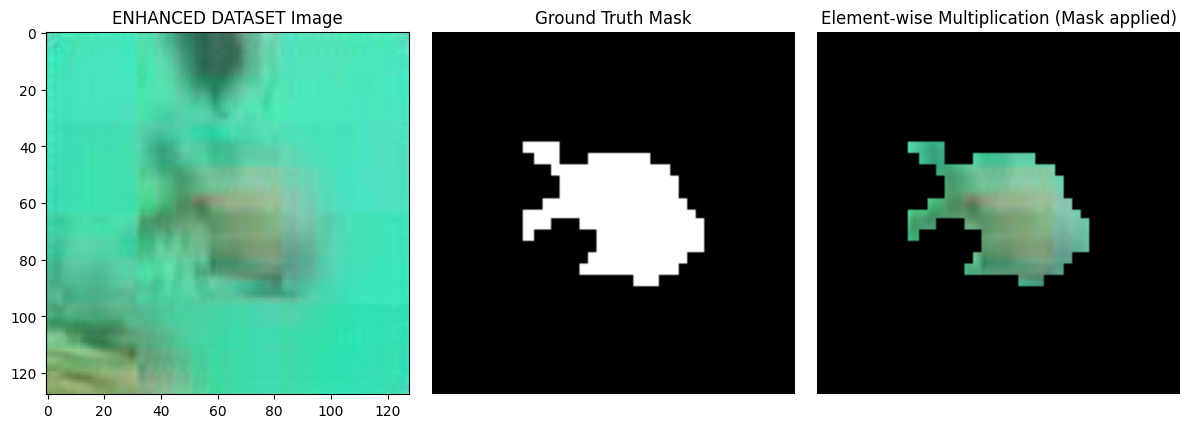

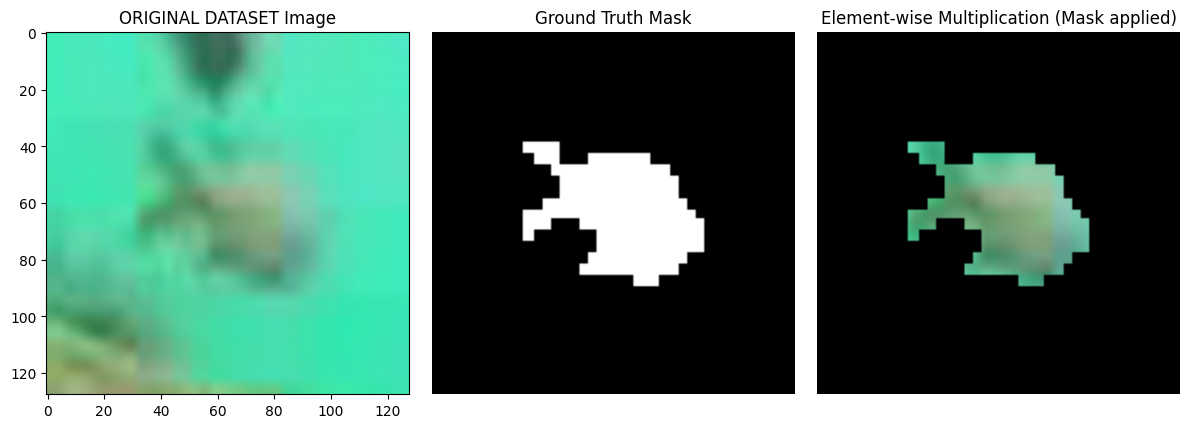

In [32]:


print(get_image_index('fish_000000019596_03647.png'))
# sample_index = 1  
sample_index = get_image_index('fish_000000019596_03647.png')

test_image_orig = train_images_orig[sample_index]  


test_img = train_images[sample_index]  

ground_truth = train_masks[sample_index] 

print('GT SHAPE = ', ground_truth.shape)

masked_image = test_img * ground_truth
masked_image2 = test_image_orig * ground_truth

# Plotting the images
plt.figure(figsize=(12, 8))

# Plot the testing image
plt.subplot(1, 3, 1)

plt.title('ENHANCED DATASET Image')
plt.imshow(test_img)  

# Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(ground_truth,cmap='gray')  
plt.axis('off')  

# Plot the masked image
plt.subplot(1, 3, 3)  
plt.title('Element-wise Multiplication (Mask applied)')
plt.imshow(masked_image)  
plt.axis('off')  

plt.tight_layout()
plt.show()



# Plotting the images
plt.figure(figsize=(12, 8))

# Plot the testing image
plt.subplot(1, 3, 1)

plt.title('ORIGINAL DATASET Image')
plt.imshow(test_image_orig)  

# Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(ground_truth,cmap='gray')  
plt.axis('off')  

# Plot the masked image
plt.subplot(1, 3, 3)  
plt.title('Element-wise Multiplication (Mask applied)')
plt.imshow(masked_image2)  
plt.axis('off')  

plt.tight_layout()
plt.show()


**TRAINING**

In [7]:
image_path = "./data/DATASET/TRAIN_UNET/enhanced_images/*.jpg"
mask_path = "./data/DATASET/TRAIN_UNET/mask/*.png"
images, masks = load_images_and_masks(image_path, mask_path)

# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(images, masks, test_size=0.10, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=0)

print(f"Training images shape: {X_train.shape}")
print(f"Training masks shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}")
print(f"Validation masks shape: {y_val.shape}")
print(f"Test images shape: {X_test.shape}")
print(f"Test masks shape: {y_test.shape}")

print("Number of training images:", len(X_train))
print("Number of training masks:", len(y_train))

print("Number of validation images:", len(X_val))
print("Number of validation masks:", len(y_val))

print("Number of test images:", len(X_test))
print("Number of test masks:", len(y_test))

print(np.unique(masks))




Training images shape: (1727, 128, 128, 3)
Training masks shape: (1727, 128, 128, 1)
Validation images shape: (432, 128, 128, 3)
Validation masks shape: (432, 128, 128, 1)
Test images shape: (240, 128, 128, 3)
Test masks shape: (240, 128, 128, 1)
Number of training images: 1727
Number of training masks: 1727
Number of validation images: 432
Number of validation masks: 432
Number of test images: 240
Number of test masks: 240
[0 1]


In [9]:
n_classes = 1
BACKBONE = 'resnet50' 

preprocess_input_unet = sm.get_preprocessing(BACKBONE) 

unet_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='sigmoid') 
 
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() 
total_loss = dice_loss + focal_loss 
 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)] 

LR = 0.001
# optim = Adam(learning_rate=LR, weight_decay=1e-4)

optim = Adam(learning_rate=LR)

# print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# train_dataset = data_generator(X_train, y_train, batch_size=8, augment=True)
# val_dataset = data_generator(X_val, y_val, batch_size=8, augment=False)
# test_dataset = data_generator(X_test, y_test, batch_size=8, augment=False)


X_train = preprocess_input_unet(X_train)
X_val = preprocess_input_unet(X_val)
X_test = preprocess_input_unet(X_test)

y_train = y_train.astype(np.float32) 
y_val = y_val.astype(np.float32)  
y_test = y_test.astype(np.float32)

unet_model.compile(
    optim,
    loss=total_loss,
    metrics=metrics,
)



In [ ]:
unet_model.summary()

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_unetmodel2.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

unet_history = unet_model.fit(X_train, y_train, batch_size=8, epochs=10, verbose=1, validation_data=(X_val, y_val))

**Training Setup #2**

In [ ]:

SIZE_X, SIZE_Y = 128, 128
n_classes = 1

# --- Augmentation Pipeline ---
augmentation_pipeline = A.Compose([
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.9),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomScale(scale_limit=0.1, p=1.0),
    A.VerticalFlip(p=0.2),
    # A.GaussianBlur(blur_limit=(3, 7), sigma_limit=(0.1, 2), p=1),
    # A.RandomBrightnessContrast(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=0.5),
], additional_targets={"mask": "mask"})


# --- Function to Apply Augmentations ---
def augment_image_and_mask(image, mask):
    augmented = augmentation_pipeline(image=image, mask=mask)
    return augmented["image"], augmented["mask"]

# --- Load and Preprocess Data ---
train_images = []
train_masks = []

for img_path, mask_path in zip(
        glob.glob("./data/DATASET/TRAIN_UNET/enhanced_images/*.jpg"),
        glob.glob("./data/DATASET/TRAIN_UNET/mask/*.png")
    ):
    # Read images and masks
    img = cv2.imread(img_path, 1)
    mask = cv2.imread(mask_path, 0)

    # Resize and preprocess
    img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_CUBIC)
    mask = (mask > 0).astype(np.uint8)

    # Append to lists
    train_images.append(img)
    train_masks.append(mask)

# --- Split Data ---
train_images = tf.clip_by_value(train_images, 0, 255).numpy().astype(np.uint8)  
train_images = np.array(train_images, dtype=np.uint8)

train_masks = np.array(train_masks, dtype=np.uint8)
train_masks = np.expand_dims(train_masks, axis=-1)
train_masks = (train_masks > 0).astype(np.uint8)

X_train_full, X_test, y_train_full, y_test = train_test_split(train_images, train_masks, test_size=0.10, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.10, random_state=0)


# --- Apply Augmentations to Training Data ---
aug_train_images = []
aug_train_masks = []

for img, mask in zip(X_train, y_train):
    # Apply augmentations
    aug_img, aug_mask = augment_image_and_mask(img, mask)

    # Resize to consistent size
    aug_img = cv2.resize(aug_img, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_CUBIC)
    aug_mask = cv2.resize(aug_mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_CUBIC)

    # Append to augmented lists
    aug_train_images.append(aug_img)
    aug_train_masks.append(aug_mask)

# Convert to numpy arrays
aug_train_images = np.array(aug_train_images, dtype=np.uint8)
aug_train_masks = np.array(aug_train_masks, dtype=np.uint8)

# --- Ensure Image Values are Clipped and Converted Properly ---
aug_train_images = np.clip(aug_train_images, 0, 255).astype(np.uint8)
aug_train_masks = np.expand_dims(aug_train_masks, axis=-1)  # Add channel dimension to masks
aug_train_masks = (aug_train_masks > 0).astype(np.uint8)


# --- Convert to Tensor --- 
aug_train_images = tf.convert_to_tensor(aug_train_images, dtype=tf.float32)
aug_train_masks = tf.convert_to_tensor(aug_train_masks, dtype=tf.float32)

# --- Ensure Images and Masks are Correct Shape ---
print(f"Training images shape: {aug_train_images.shape}")
print(f"Training masks shape: {aug_train_masks.shape}")
print(f"Validation images shape: {X_val.shape}")
print(f"Validation masks shape: {y_val.shape}")
print(f"Test images shape: {X_test.shape}")
print(f"Test masks shape: {y_test.shape}")

# --- Preprocess Images ---
BACKBONE = 'resnet50'
preprocess_input_unet = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input_unet(aug_train_images)
X_val = preprocess_input_unet(X_val)
X_test = preprocess_input_unet(X_test)

y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

# --- Define U-Net ---
unet_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='sigmoid')

# --- Loss, Metrics, and Optimizer ---
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 0.5]))
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + focal_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

optim = Adam(learning_rate=0.0001)

unet_model.compile(optim, loss=total_loss, metrics=metrics)

# --- Callbacks ---
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_unetmodel.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- Train Model ---
unet_history = unet_model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


**END======================================Save Model======================================END**

In [50]:

unet_model.save('./saved_models/unetb8epoch1f-1-93notenhancedlr-001iou-91-valiou-84.h5')


with open('./saved_models/unetb8epoch1f-1-93notenhancedlr-001iou-91-valiou-84_history.pkl', 'wb') as file:
    pickle.dump(unet_history.history, file)

**LOAD THE MODEL**

In [64]:


with open('./saved_models/unetb8epoch10f-1-93enhancedlr-001iou-87-valiou-86_history.pkl', 'rb') as file:
    unet_history = pickle.load(file)


True


In [ ]:
unet_model = load_model('./saved_models/best_unetmodel.keras', compile=False)

In [ ]:


sample_index = get_image_index('fish_000000019596_03647.jpg')

test_img2 = train_images[sample_index] 

# test_img = train_images_orig[sample_index] 

ground_truth = train_masks[sample_index] 

# print(test_img.shape)
# masked_image = test_img * ground_truth

# predicted_mask = unetmodel.predict(np.expand_dims(test_img, axis=0))
predicted_mask2 = unet_model.predict(np.expand_dims(test_img2, axis=0))

# print(predicted_mask.shape)
# predicted_mask = np.squeeze(predicted_mask)
# print(predicted_mask.shape)
predicted_mask2 = np.squeeze(predicted_mask2)

# binary_mask = (predicted_mask > 0.1).astype(np.uint8)
binary_mask2 = (predicted_mask2 > 0.4).astype(np.uint8)

# print(np.min(predicted_mask), np.max(predicted_mask))

# masked_image_pred = test_img * np.expand_dims(binary_mask, axis=-1)
masked_image_pred2 = test_img2 * np.expand_dims(binary_mask2, axis=-1)

# Plotting the images
plt.figure(figsize=(12, 8))

# Plot the testing image
plt.subplot(1, 3, 1)
plt.title('ORIGINAL Image')
plt.imshow(test_img) 
plt.axis('off') 

# Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(ground_truth)  
plt.axis('off')  

# Plot the masked image using the ground truth mask
plt.subplot(1, 3, 3)
plt.title('Element-wise Multiplication (Ground Truth Mask applied)')
plt.imshow(masked_image)  
plt.axis('off') 



# Plotting the predicted mask
plt.figure(figsize=(12, 8))

# Plot the testing image
plt.subplot(1, 3, 1)
plt.title('ENHANCED Image')
plt.imshow(test_img2) 
plt.axis('off') 

# Plot the predicted mask
plt.subplot(1, 3, 2)
plt.title('Predicted Mask')
plt.imshow(binary_mask2)  
plt.axis('off')

# Plot the masked image using the predicted mask
plt.subplot(1, 3, 3)
plt.title('Element-wise Multiplication (Predicted Mask applied)')
plt.imshow(masked_image_pred2)  
plt.axis('off')




# # Plotting the predicted mask
# plt.figure(figsize=(12, 8))

# # Plot the testing image
# plt.subplot(1, 3, 1)
# plt.title('ORIGNAL Image')
# plt.imshow(test_img) 
# plt.axis('off') 

# # Plot the predicted mask
# plt.subplot(1, 3, 2)
# plt.title('Predicted Mask')
# plt.imshow(binary_mask)  
# plt.axis('off')

# # Plot the masked image using the predicted mask
# plt.subplot(1, 3, 3)
# plt.title('Element-wise Multiplication (Predicted Mask applied)')
# plt.imshow(masked_image_pred)  
# plt.axis('off')






# U-NET
PREFFERED : unetb8epoch10f-1-93notenhancedlr-001iou-91-valiou-84 THRESHOLD 3

In [57]:
# Specify the custom objects in load_model
unet_model = load_model(
    './saved_models/best_unetmodel.keras', compile=False
)


iamge name:  fish_000011519592_03440.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000011519592_03440.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(128, 128)


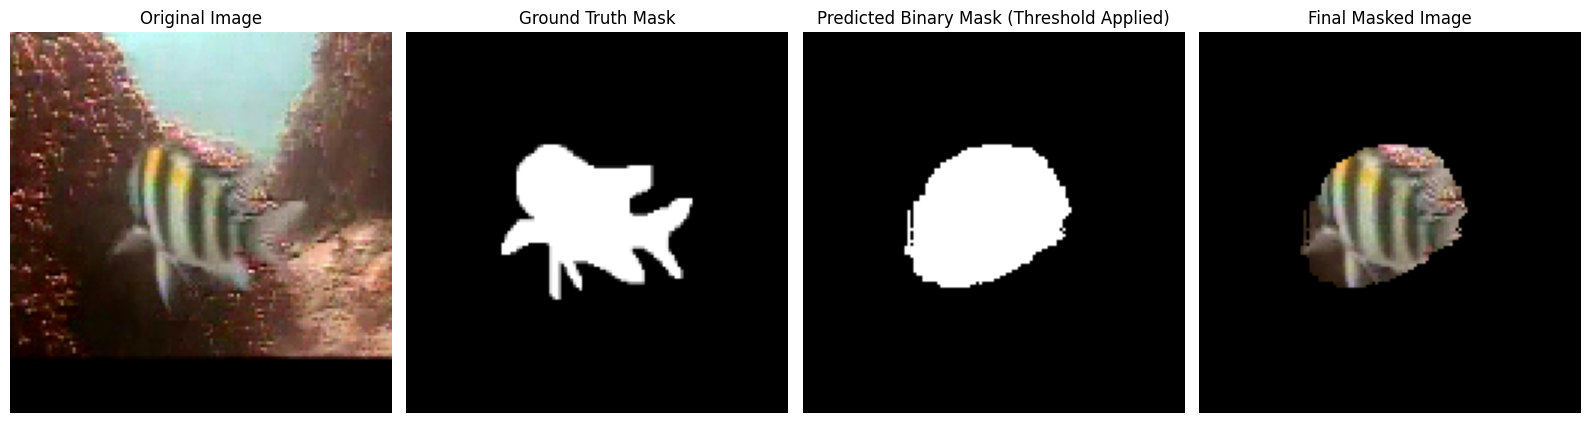

iamge name:  fish_000011519592_03442.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000011519592_03442.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
(128, 128)


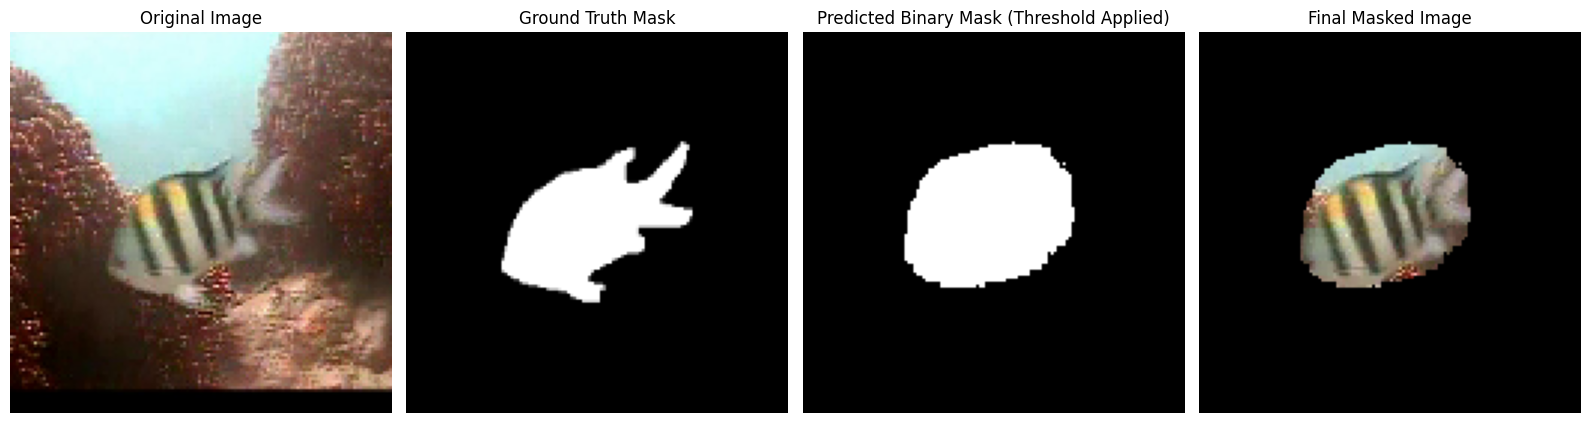

iamge name:  fish_000011519592_03445.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000011519592_03445.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
(128, 128)


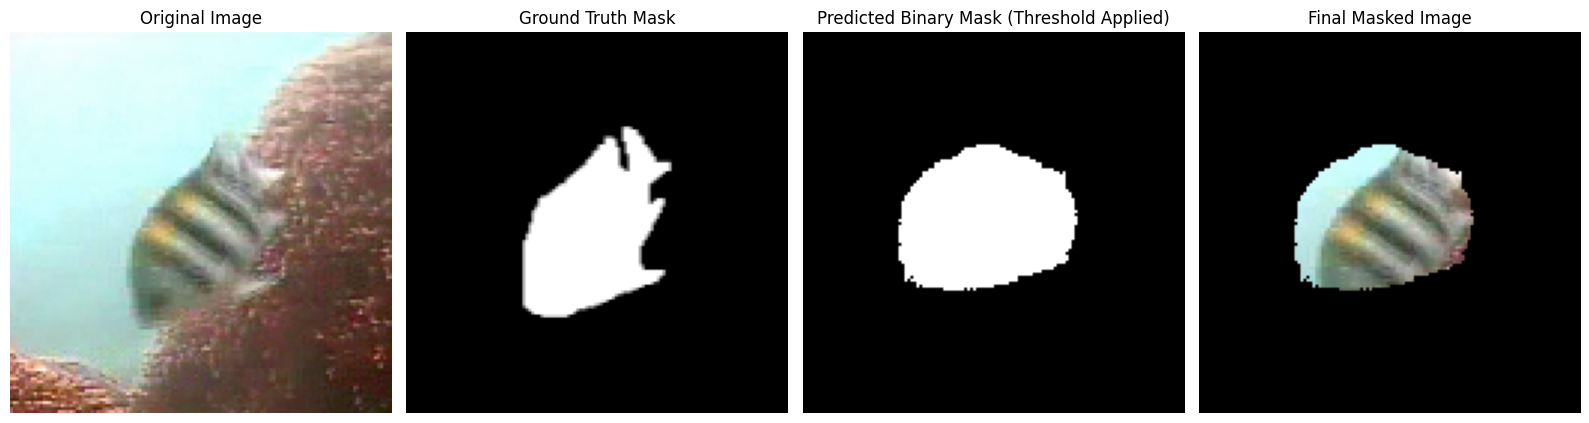

iamge name:  fish_000064639598_06211.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000064639598_06211.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
(128, 128)


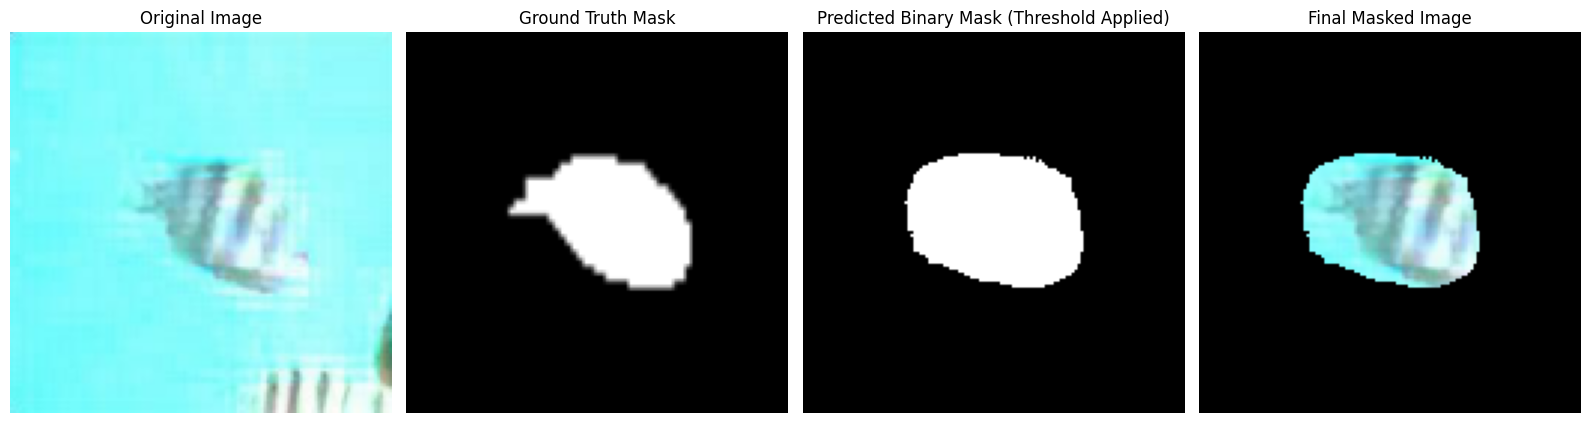

iamge name:  fish_003389205223_25941.jpg
./data/DATASET/TRAIN_UNET/mask\mask_003389205223_25941.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
(128, 128)


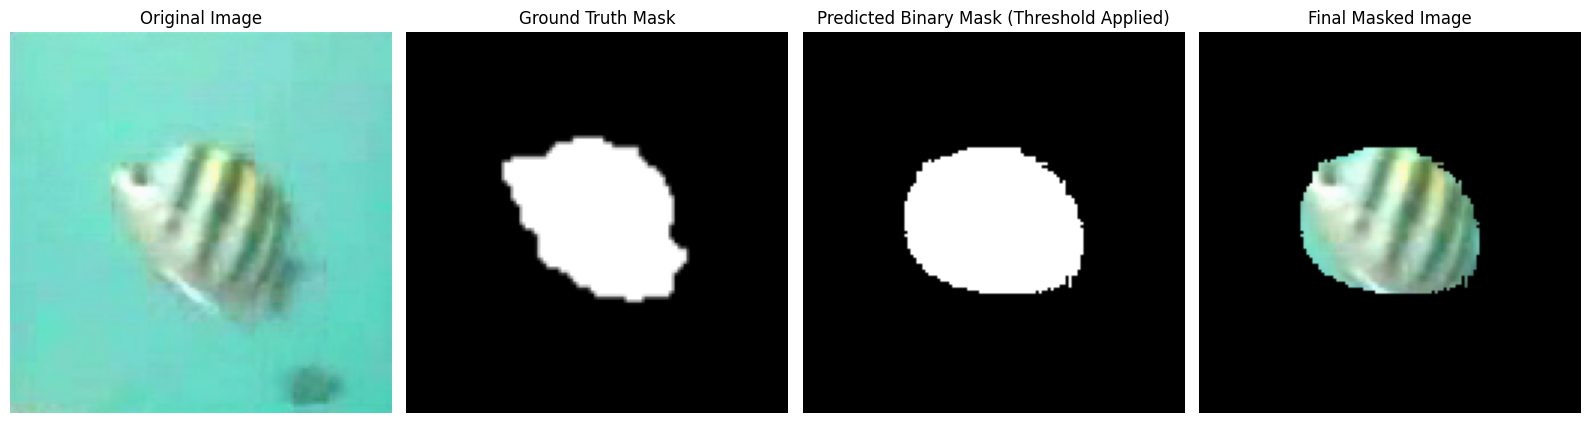

iamge name:  fish_000016839596_03984.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000016839596_03984.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
(128, 128)


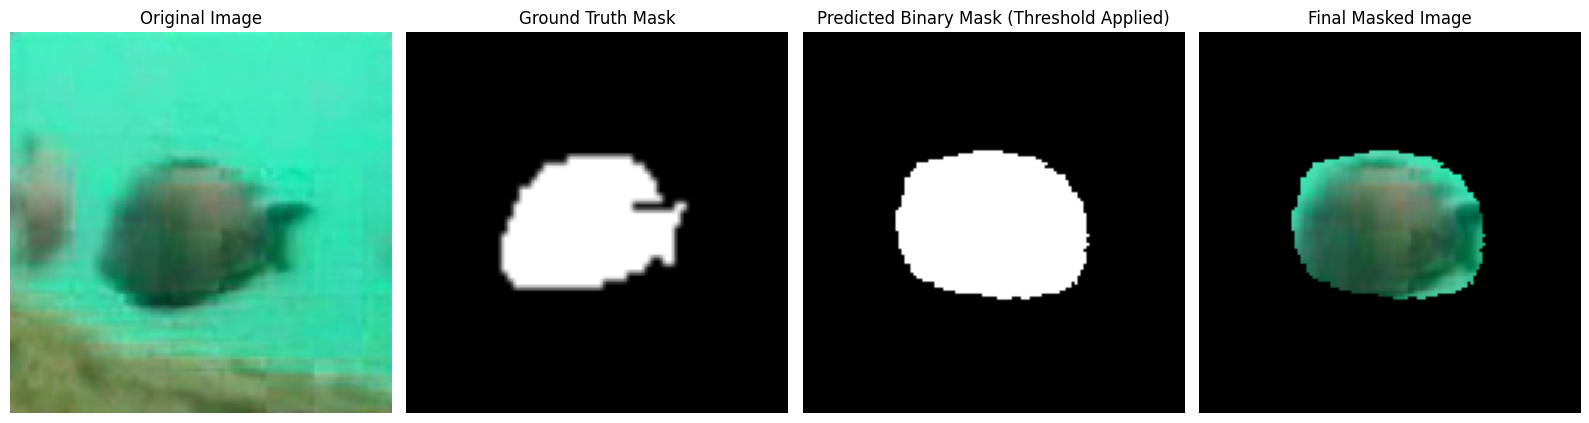

iamge name:  fish_000026310001_02569.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000026310001_02569.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
(128, 128)


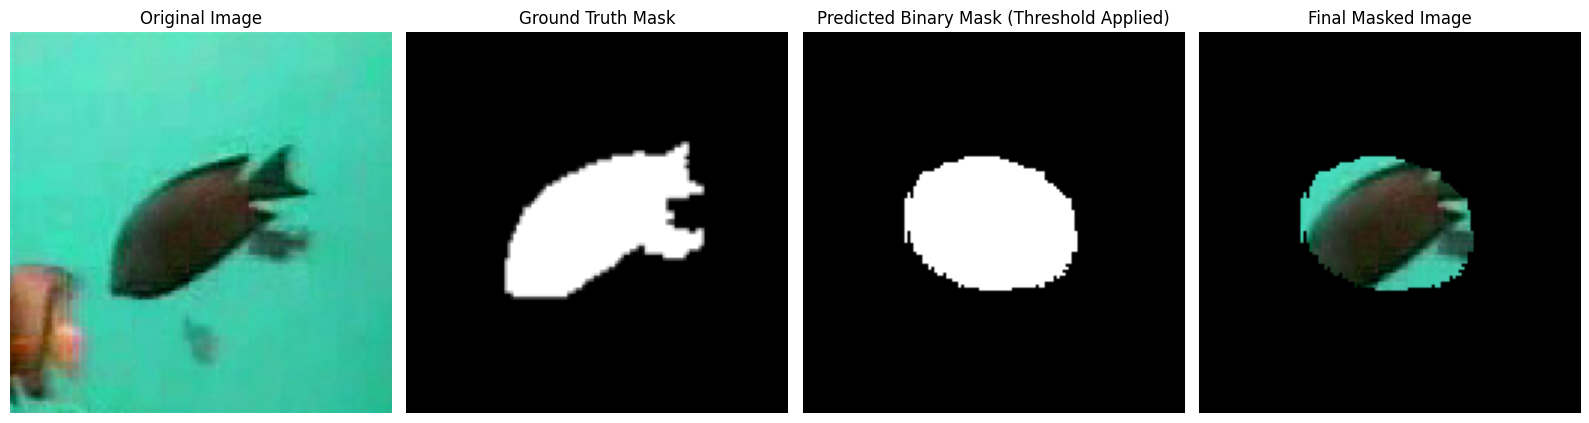

iamge name:  fish_000026380001_02581.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000026380001_02581.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
(128, 128)


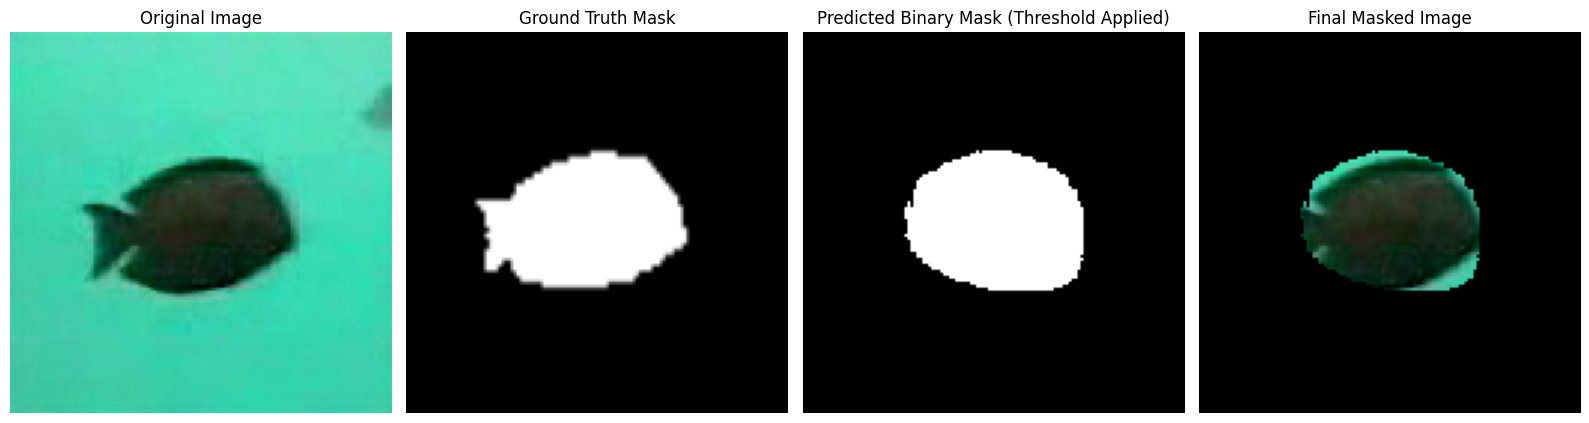

iamge name:  fish_000026610001_02661.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000026610001_02661.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
(128, 128)


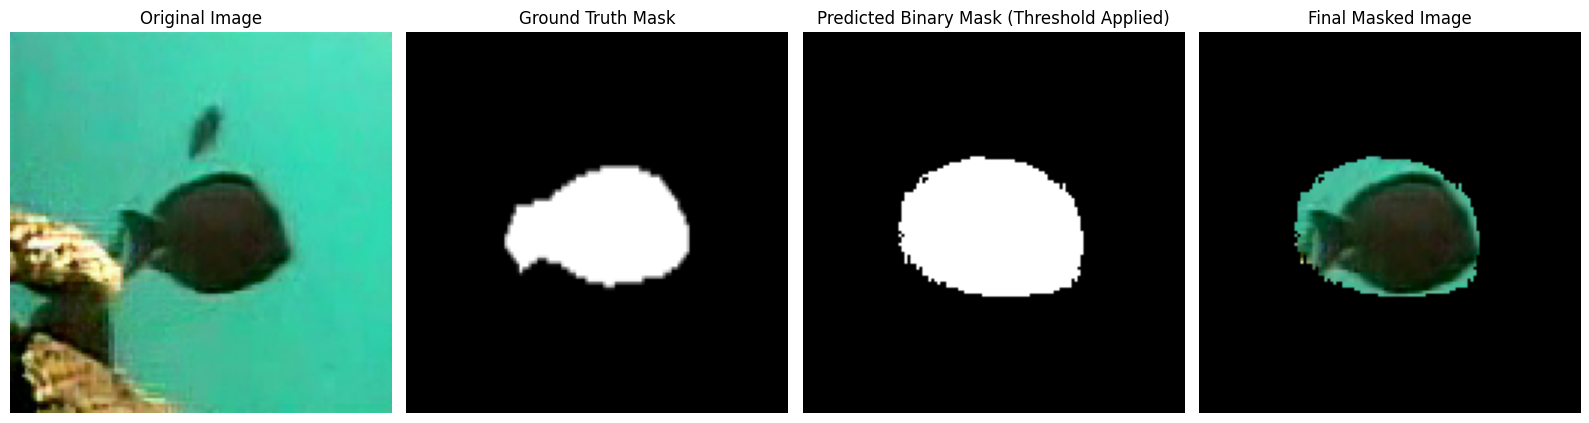

iamge name:  fish_000026930001_02779.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000026930001_02779.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
(128, 128)


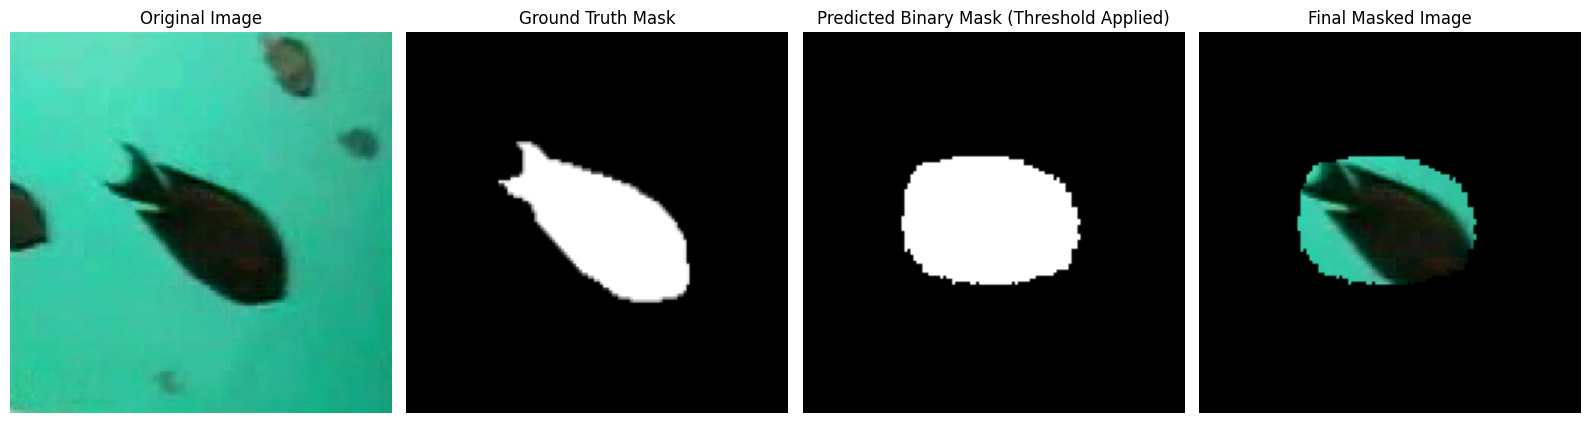

iamge name:  fish_000021760001_01812.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000021760001_01812.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
(128, 128)


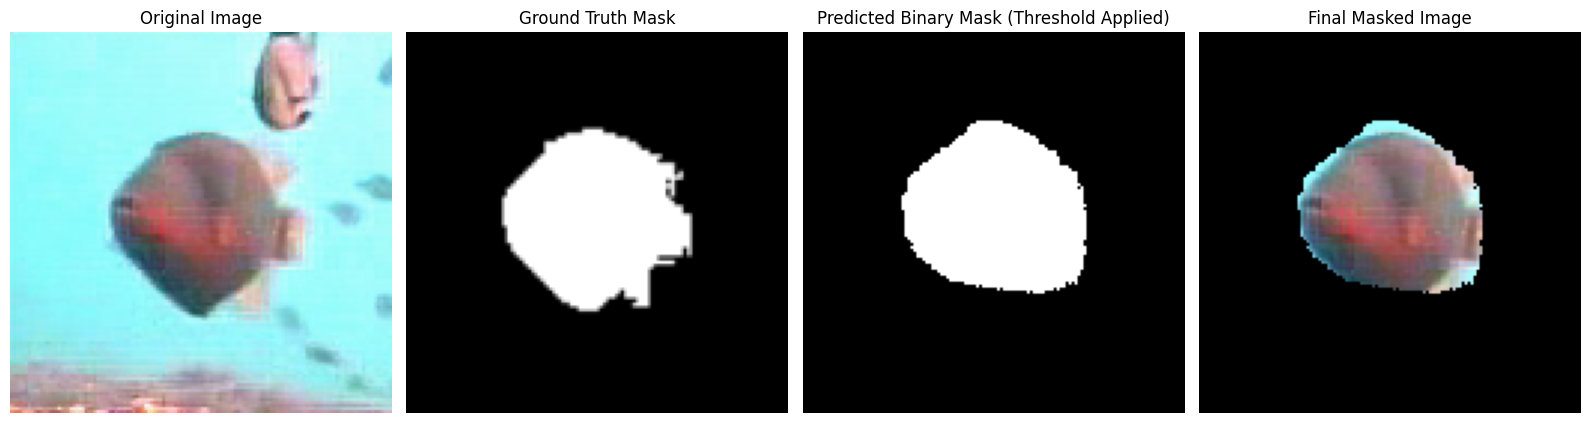

iamge name:  fish_000021760001_01817.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000021760001_01817.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
(128, 128)


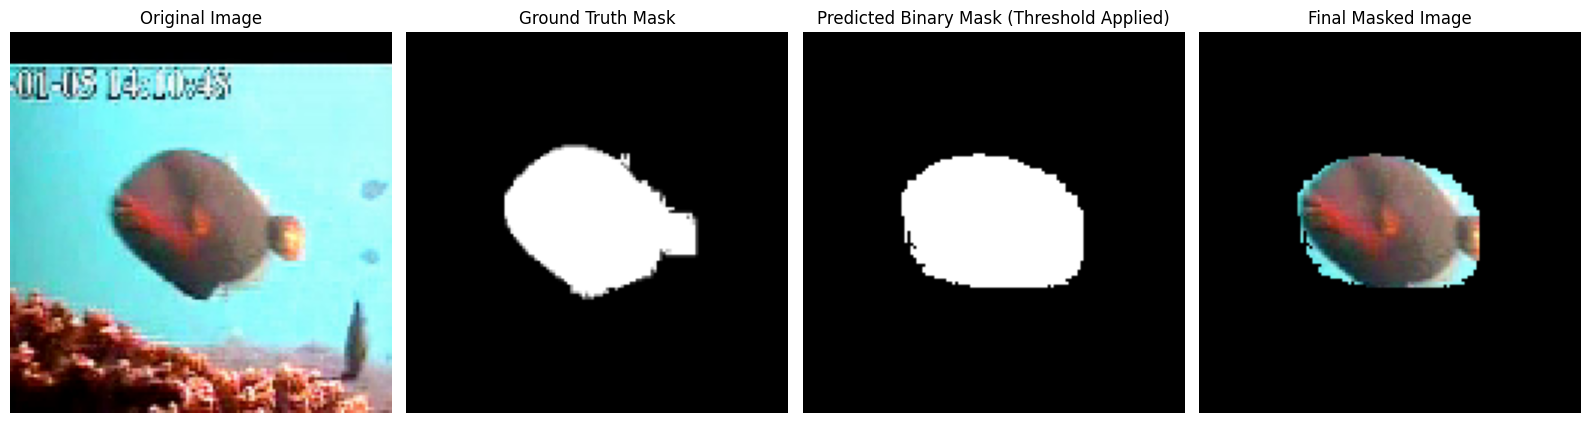

iamge name:  fish_000021830001_01843.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000021830001_01843.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
(128, 128)


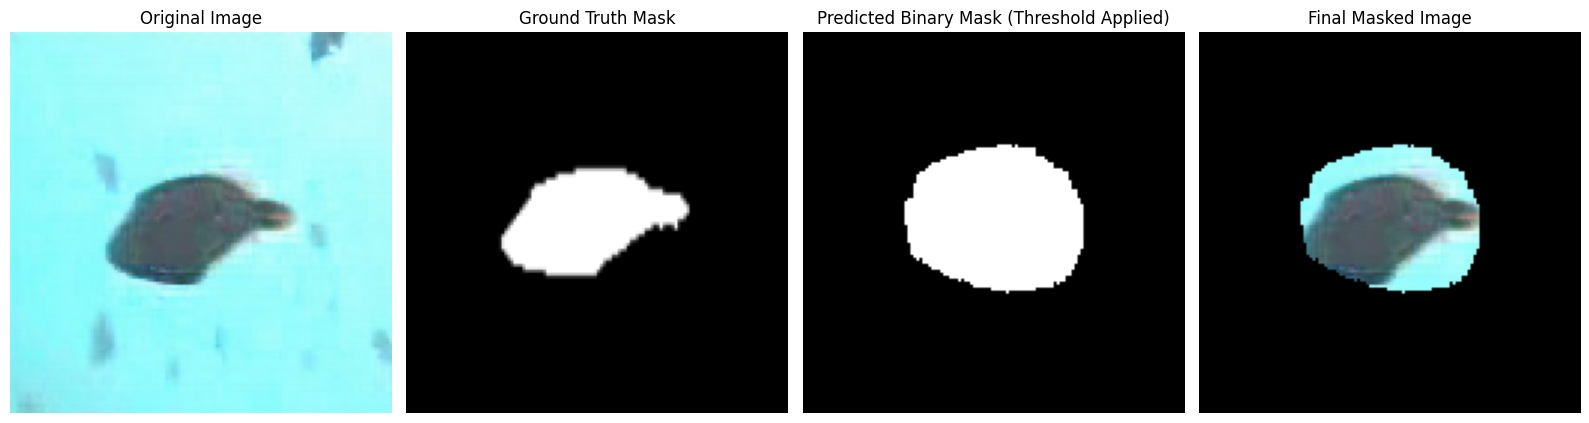

iamge name:  fish_000021830001_01844.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000021830001_01844.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
(128, 128)


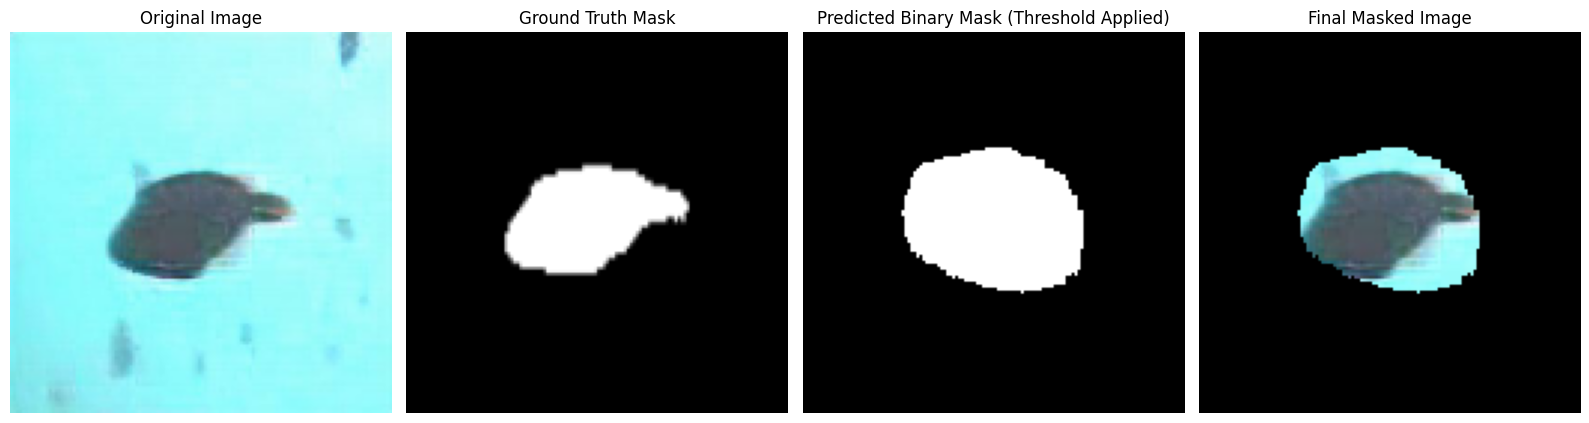

iamge name:  fish_000021830001_01846.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000021830001_01846.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
(128, 128)


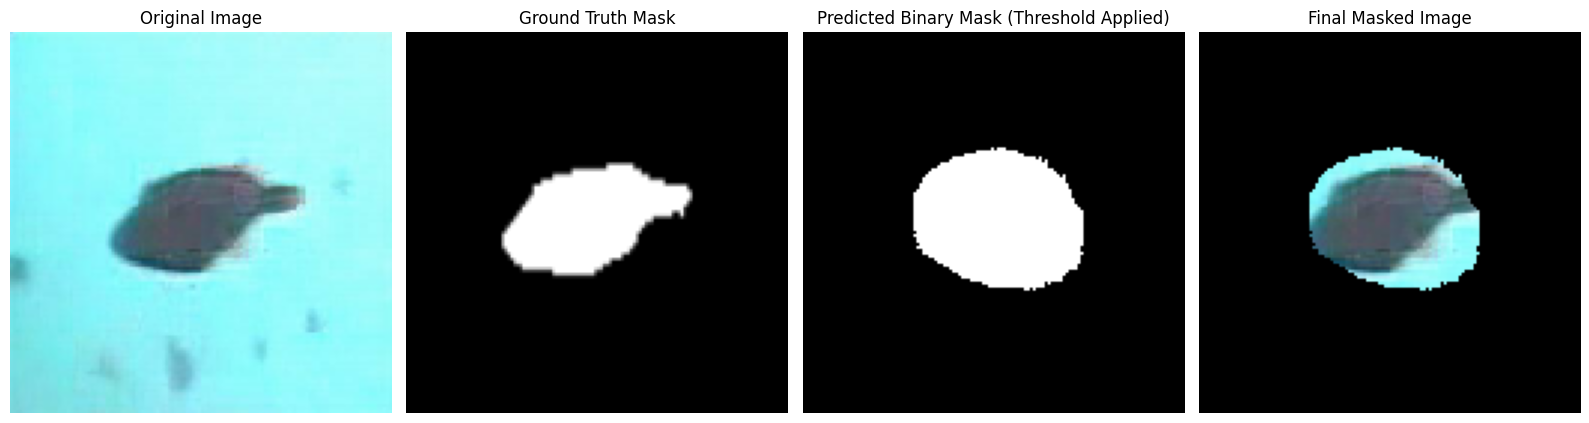

iamge name:  fish_003424815280_19252.jpg
./data/DATASET/TRAIN_UNET/mask\mask_003424815280_19252.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
(128, 128)


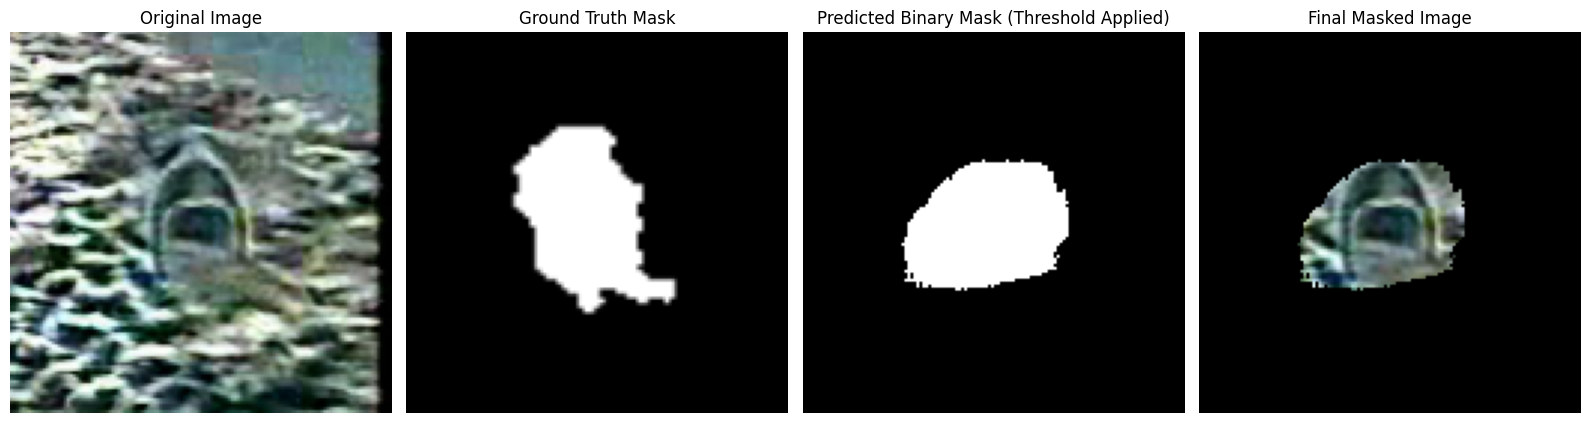

iamge name:  fish_003424815280_26242.jpg
./data/DATASET/TRAIN_UNET/mask\mask_003424815280_26242.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
(128, 128)


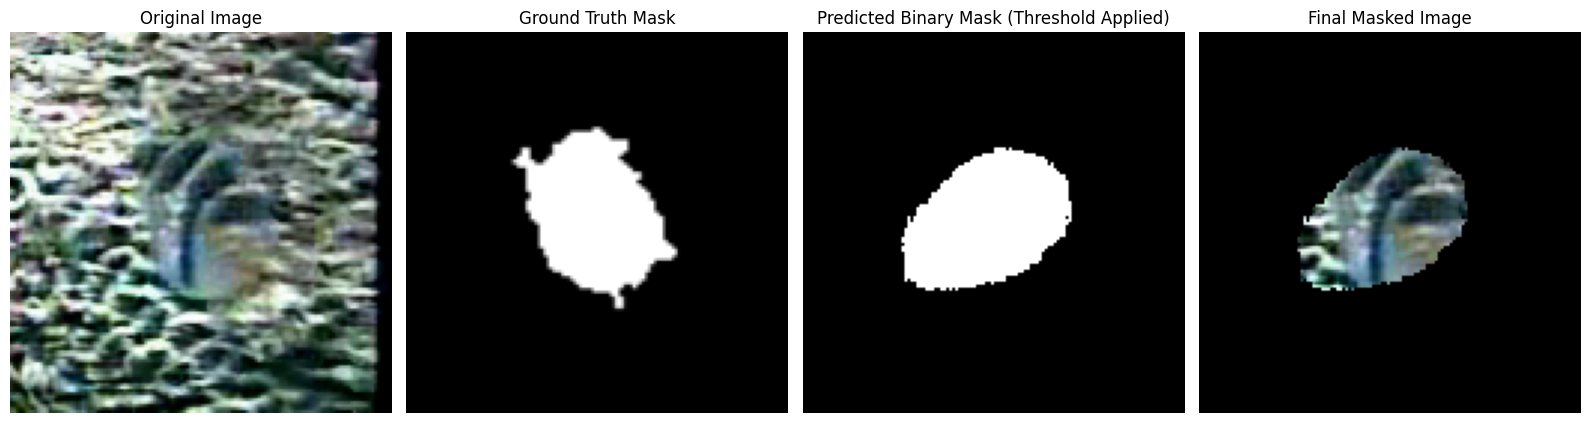

iamge name:  fish_003553545474_09050.jpg
./data/DATASET/TRAIN_UNET/mask\mask_003553545474_09050.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
(128, 128)


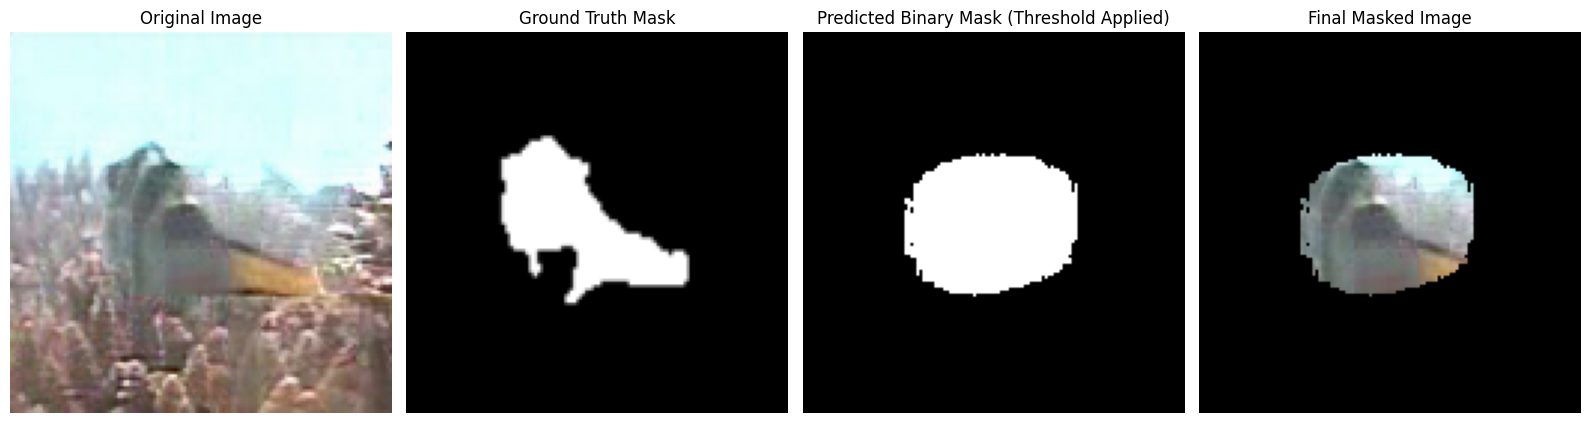

iamge name:  fish_003553545474_20340.jpg
./data/DATASET/TRAIN_UNET/mask\mask_003553545474_20340.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
(128, 128)


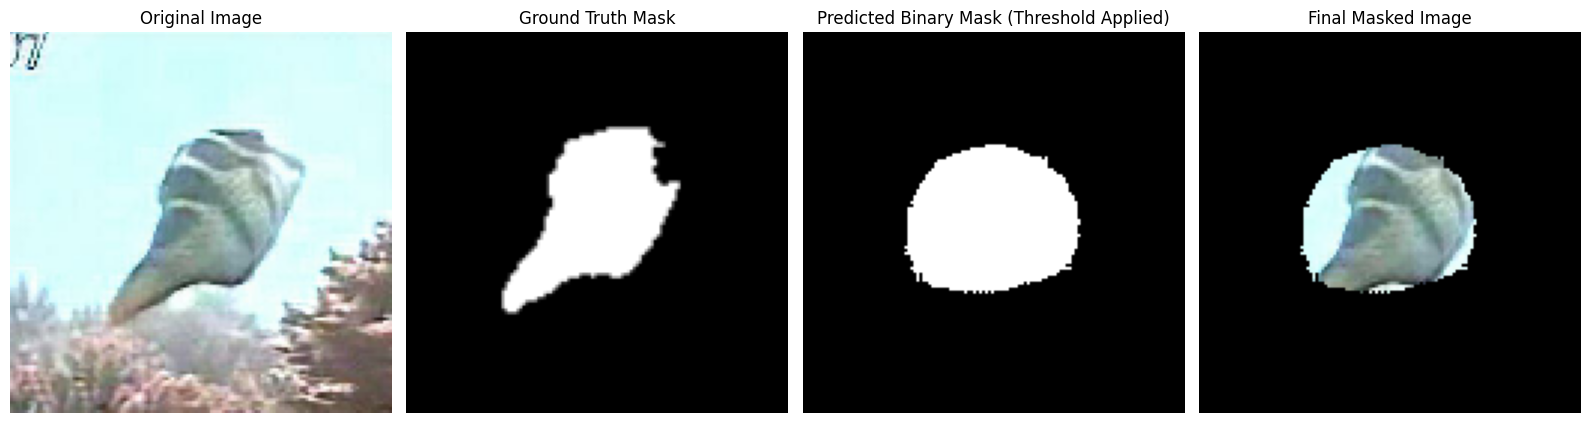

iamge name:  fish_003571805521_09660.jpg
./data/DATASET/TRAIN_UNET/mask\mask_003571805521_09660.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
(128, 128)


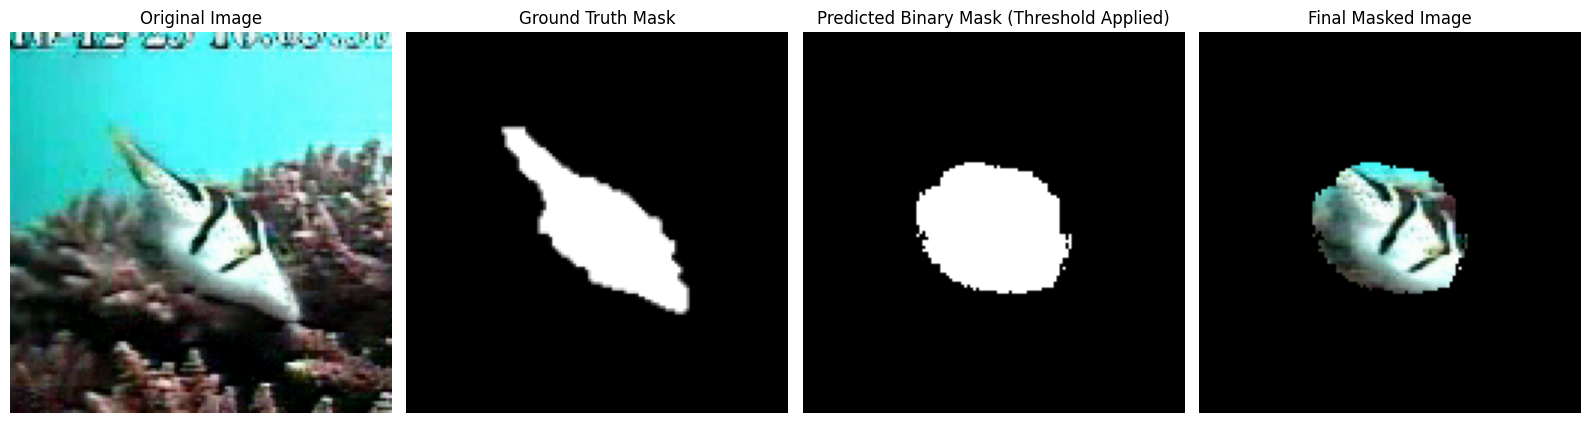

iamge name:  fish_000004210001_00030.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000004210001_00030.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
(128, 128)


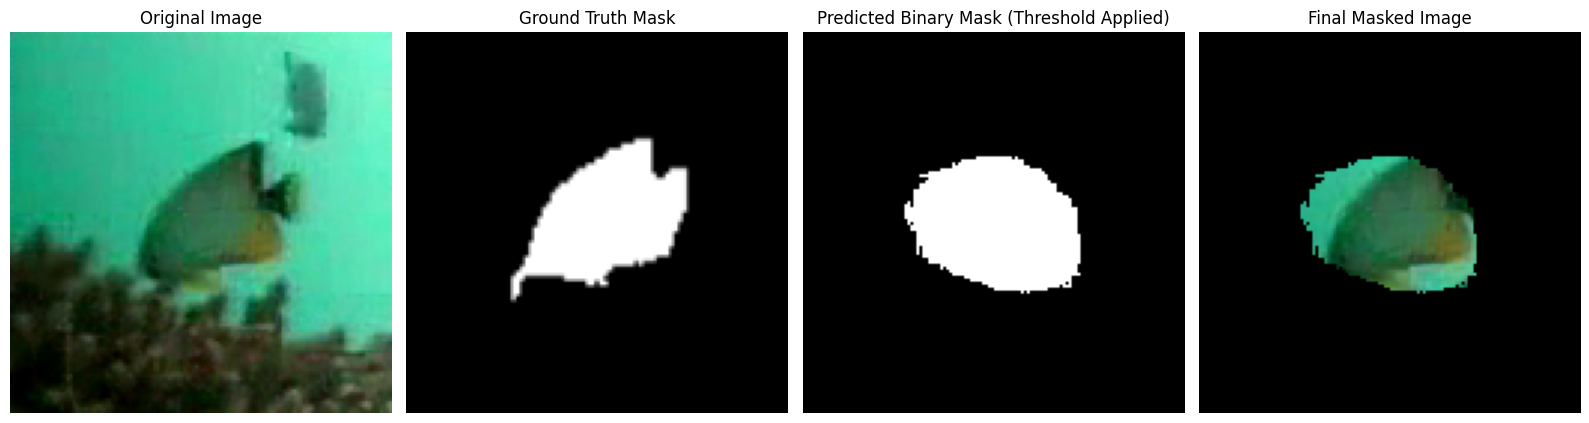

iamge name:  fish_000004710001_00476.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000004710001_00476.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
(128, 128)


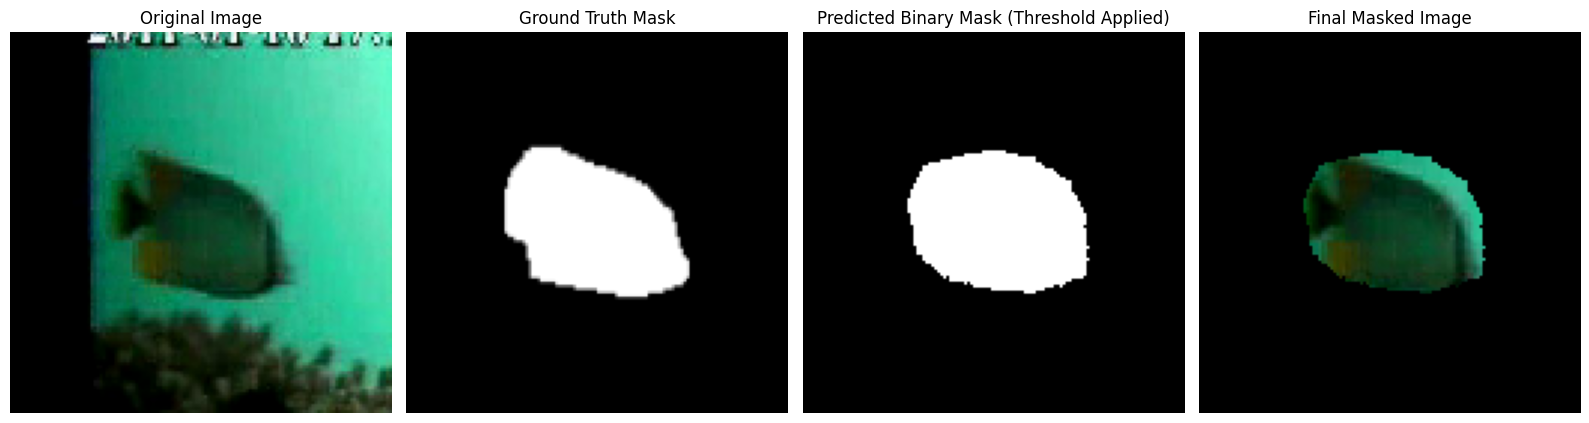

iamge name:  fish_000004900001_00636.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000004900001_00636.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
(128, 128)


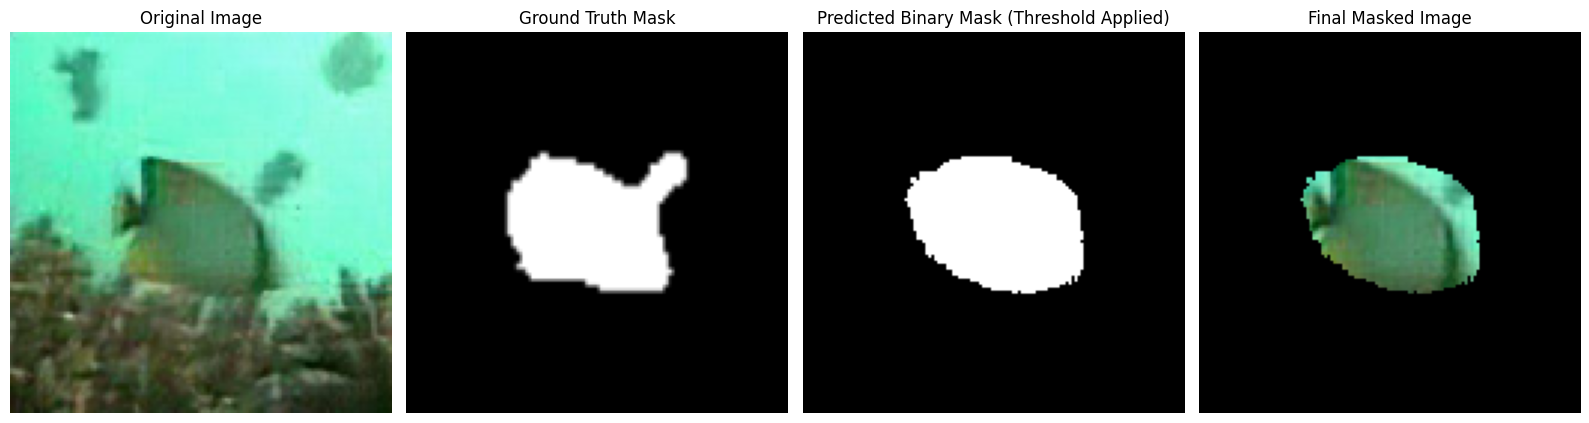

iamge name:  fish_000004900001_00638.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000004900001_00638.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
(128, 128)


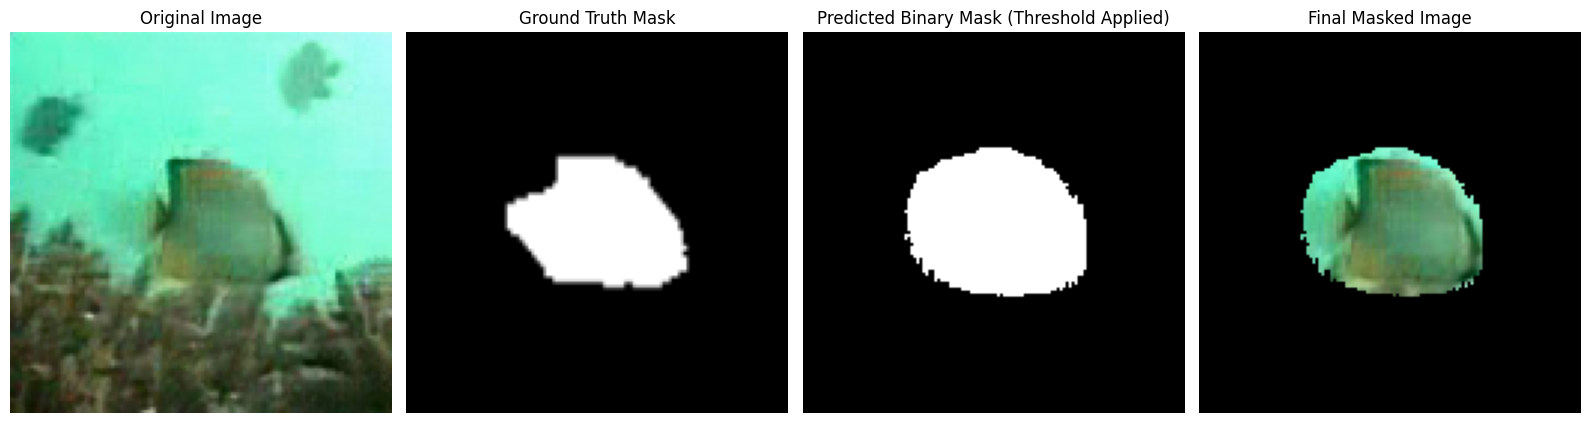

iamge name:  fish_000004960001_00658.jpg
./data/DATASET/TRAIN_UNET/mask\mask_000004960001_00658.png
(128, 128)
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
(128, 128)


KeyboardInterrupt: 

In [58]:

SIZE_X, SIZE_Y = 128, 128

# Define paths for input and output directories
input_dirs = {"test": "./data/DATASET/TEST_ESRGAN"}
output_dirs = {"test": "./data/DATASET/TEST_ESRGAN_UNET"}
mask_dir = './data/DATASET/TRAIN_UNET/mask'
# Create output directories if they don't exist
for split, output_dir in output_dirs.items():
    os.makedirs(output_dir, exist_ok=True)
    for species in os.listdir(input_dirs[split]):
        os.makedirs(os.path.join(output_dir, species), exist_ok=True)

# Parameters
threshold = 0.5 # Threshold for binary mask

def get_corresponding_mask(image_filename):
    fishnumber = image_filename.split('_')[1] + '_' + image_filename.split('_')[2].split('.')[0]  
    
    mask_filename = f"mask_{fishnumber}.png"
    
    mask_path = os.path.join(mask_dir, mask_filename)
    
    if os.path.exists(mask_path):
        return mask_path
    else:
        print(f"Mask not found for: {mask_filename}")  
        return None


def process_all():
    # Process the test set and display images at each step
    for split, input_dir in input_dirs.items():
        output_dir = output_dirs[split]

        for species in os.listdir(input_dir):
            species_dir = os.path.join(input_dir, species)
            output_species_dir = os.path.join(output_dir, species)

            display_count = 0

            for img_name in os.listdir(species_dir):
                if display_count >= 5:  # Stop plotting after 5 images
                    break
                print('iamge name: ', img_name)
                # Load and preprocess the image
                img_path = os.path.join(species_dir, img_name)

                image = preprocess_image(img_path)
                image = tf.image.resize(tf.squeeze(image), (SIZE_Y, SIZE_X))
                image = tf.clip_by_value(image, 0, 255).numpy().astype(np.uint8)  

                # Load the ground truth mask (Assuming ground truth masks are stored in a 'masks' folder)
                ground_truth_path = get_corresponding_mask(img_name)  
                print(ground_truth_path)
                ground_truth_mask = cv2.imread(ground_truth_path, 0)
                ground_truth_mask = cv2.resize(ground_truth_mask, (128, 128))  
                print(ground_truth_mask.shape)

            
                print(image.shape)
                predicted_mask = unet_model.predict(np.expand_dims(image, axis=0))[0]
            
                predicted_mask = np.squeeze(predicted_mask)

                # Apply threshold to create a binary mask
                binary_mask = (predicted_mask > threshold).astype(np.uint8)
                print(binary_mask.shape)

                masked_image_pred = image * np.expand_dims(binary_mask, axis=-1)

                # Display images to inspect each step
                fig, ax = plt.subplots(1, 4, figsize=(16, 8))
                ax[0].imshow(image)
                ax[0].set_title("Original Image")
                ax[0].axis('off')

                # Display the ground truth mask instead of predicted mask
                ax[1].imshow(ground_truth_mask, cmap='gray')
                ax[1].set_title("Ground Truth Mask")
                ax[1].axis('off')

                ax[2].imshow(binary_mask, cmap='gray')
                ax[2].set_title("Predicted Binary Mask (Threshold Applied)")
                ax[2].axis('off')

                ax[3].imshow(masked_image_pred)
                ax[3].set_title("Final Masked Image")
                ax[3].axis('off')

                plt.tight_layout()
                plt.show()

                display_count += 1

                # Save the output if the inspection is correct
                # output_path = os.path.join(output_species_dir, img_name)
                # cv2.imwrite(output_path, cv2.cvtColor(masked_image_pred, cv2.COLOR_RGB2BGR))

                # Stop after processing one image for initial inspection
                
process_all()
    
